In [1]:
import h5py
import importlib
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from scipy.optimize import minimize

import src.src_current_measurement
import src.src_singleshot_measurement
import src.src_current_measurement_simulations

importlib.reload(src.src_current_measurement);
importlib.reload(src.src_singleshot_measurement);
importlib.reload(src.src_current_measurement_simulations);
from src.src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename, acquire_data
from src.src_singleshot_measurement import Singleshot_2Q_Measurement, Singleshot_1Q_Measurement, generate_singleshot_2Q_filename, generate_singleshot_1Q_filename
from src.src_current_measurement_simulations import CurrentMeasurementSimulation

In [2]:
test_filepath = generate_current_calibration_filename('2025', '07', '14', '15', '54', '57')
test_filepath = generate_current_calibration_filename('2025', '07', '14', '16', '18', '26') # correlations
test_filepath = generate_current_calibration_filename('2025', '07', '14', '16', '20', '13') # no correlations
test_filepath = generate_current_calibration_filename('2025', '07', '14', '16', '33', '06') # negative correlations

times, population_shots = acquire_data(test_filepath)

timestep before multiplication: 4.0 ns
timestep after multiplication: 1.162575 ns


In [ ]:
print(population_shots.shape)

(4, 101, 1000)


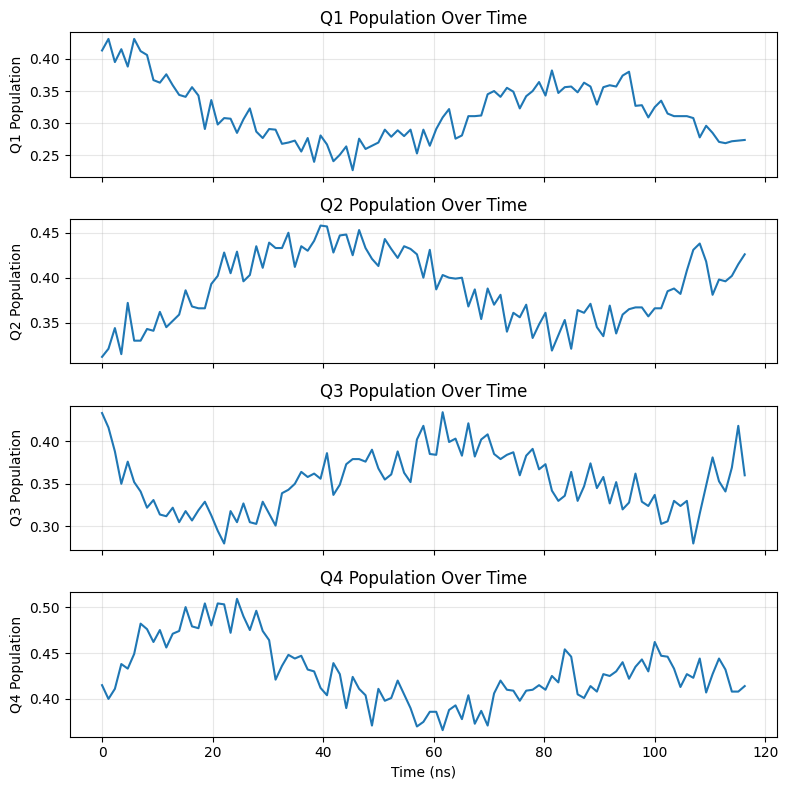

In [7]:
fig, axes = plt.subplots(population_shots.shape[0], 1, figsize=(8, 2 * population_shots.shape[0]), sharex=True)

for i in range(population_shots.shape[0]):
    axes[i].plot(times, np.mean(population_shots[i, :, :], axis=-1))
    axes[i].set_ylabel(f'Q{i+1} Population')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_title(f'Q{i+1} Population Over Time')

axes[-1].set_xlabel('Time (ns)')
plt.tight_layout()
plt.show()

In [6]:
# calculate correlations

Q1_Q2_difference = population_shots[1,:,:] - population_shots[0,:,:]
Q3_Q4_difference = population_shots[3,:,:] - population_shots[2,:,:]

plt.plot(times, np.mean(Q1_Q2_difference, axis=-1), label='Q1 - Q2')
plt.plot(times, np.mean(Q3_Q4_difference, axis=-1), label='Q3 - Q4')
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference')
plt.legend()
plt.show()

NameError: name 'population_shots' is not defined

In [7]:
print(Q1_Q2_difference[:,0])
print(Q3_Q4_difference[:,0])

### plot just the first shot for all time
plt.plot(times, Q1_Q2_difference[:, 0], label='Q1-Q2 Difference')
plt.plot(times, Q3_Q4_difference[:, 0], label='Q3-Q4 Difference')
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference')
plt.legend()
plt.show()


NameError: name 'Q1_Q2_difference' is not defined

In [8]:
Q1_Q2_difference[:,0] * Q3_Q4_difference[:,0]

NameError: name 'Q1_Q2_difference' is not defined

In [9]:
plt.plot(times, np.mean(Q1_Q2_difference * Q3_Q4_difference, axis=-1))
plt.xlabel('Time (ns)')
plt.ylabel('Correlation')
plt.show()

NameError: name 'times' is not defined

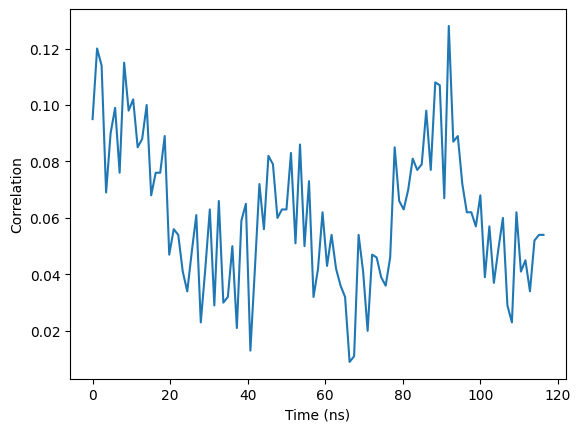
The one that should have correlations

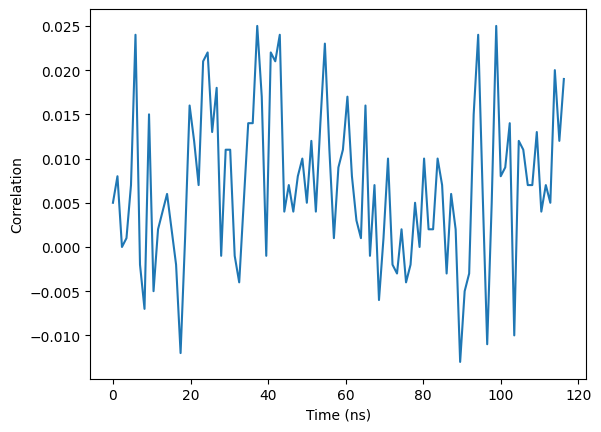

The one that should not have correlations

# Correlation Analysis Between Datasets

Since you have two datasets with discrete values (-1, 0, 1) and suspect they're correlated at each time point across shots, here are several ways to quantify this correlation:

## Methods to Consider:

1. **Pearson Correlation Coefficient** - Standard linear correlation
2. **Spearman Rank Correlation** - Non-parametric correlation for ordinal data
3. **Point-biserial/Contingency Analysis** - For categorical relationships
4. **Custom Correlation Metrics** - Specific to your physics application

In [10]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats.contingency import association
import pandas as pd

def calculate_correlations_at_timepoint(data1_t, data2_t):
    """
    Calculate various correlation metrics between two datasets at a single time point.
    
    Parameters:
    data1_t, data2_t: 1D arrays of values at a specific time point across shots
    
    Returns:
    dict: Dictionary containing different correlation measures
    """
    # Remove any NaN values
    mask = ~(np.isnan(data1_t) | np.isnan(data2_t))
    d1, d2 = data1_t[mask], data2_t[mask]
    
    results = {}
    
    # 1. Pearson correlation (linear relationship)
    if len(d1) > 1 and np.std(d1) > 0 and np.std(d2) > 0:
        pearson_corr, pearson_p = pearsonr(d1, d2)
        results['pearson_corr'] = pearson_corr
        results['pearson_p_value'] = pearson_p
    else:
        results['pearson_corr'] = np.nan
        results['pearson_p_value'] = np.nan
    
    # 2. Spearman correlation (rank-based, good for ordinal data)
    if len(d1) > 1:
        spearman_corr, spearman_p = spearmanr(d1, d2)
        results['spearman_corr'] = spearman_corr
        results['spearman_p_value'] = spearman_p
    else:
        results['spearman_corr'] = np.nan
        results['spearman_p_value'] = np.nan
    
    # 3. Custom agreement metric (percentage of exact matches)
    agreement = np.mean(d1 == d2)
    results['agreement'] = agreement
    
    # 4. Custom correlation for your specific case
    # This measures how often they have the same sign (both positive, both negative, or both zero)
    same_sign = np.mean(np.sign(d1) == np.sign(d2))
    results['same_sign_correlation'] = same_sign
    
    return results

# Test on a single time point
time_idx = 0
corr_results = calculate_correlations_at_timepoint(
    Q1_Q2_difference[time_idx, :], 
    Q3_Q4_difference[time_idx, :]
)

print(f"Correlation analysis at time point {time_idx} (t = {times[time_idx]:.2f} ns):")
for key, value in corr_results.items():
    print(f"  {key}: {value:.4f}")

NameError: name 'Q1_Q2_difference' is not defined

In [ ]:
# Calculate correlations across all time points
n_timepoints = len(times)
correlation_data = {
    'times': times,
    'pearson_corr': np.zeros(n_timepoints),
    'pearson_p': np.zeros(n_timepoints),
    'spearman_corr': np.zeros(n_timepoints),
    'spearman_p': np.zeros(n_timepoints),
    'agreement': np.zeros(n_timepoints),
    'same_sign_correlation': np.zeros(n_timepoints)
}

# Calculate for each time point
for t_idx in range(n_timepoints):
    corr_results = calculate_correlations_at_timepoint(
        Q1_Q2_difference[t_idx, :], 
        Q3_Q4_difference[t_idx, :]
    )
    
    correlation_data['pearson_corr'][t_idx] = corr_results['pearson_corr']
    correlation_data['pearson_p'][t_idx] = corr_results['pearson_p_value']
    correlation_data['spearman_corr'][t_idx] = corr_results['spearman_corr']
    correlation_data['spearman_p'][t_idx] = corr_results['spearman_p_value']
    correlation_data['agreement'][t_idx] = corr_results['agreement']
    correlation_data['same_sign_correlation'][t_idx] = corr_results['same_sign_correlation']

print("Correlation analysis complete!")
print(f"Average Pearson correlation: {np.nanmean(correlation_data['pearson_corr']):.4f}")
print(f"Average Spearman correlation: {np.nanmean(correlation_data['spearman_corr']):.4f}")
print(f"Average agreement: {np.nanmean(correlation_data['agreement']):.4f}")
print(f"Average same-sign correlation: {np.nanmean(correlation_data['same_sign_correlation']):.4f}")

In [ ]:
# Plot correlation metrics over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Pearson correlation
axes[0, 0].plot(times, correlation_data['pearson_corr'], 'b.-', alpha=0.7)
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 0].set_title('Pearson Correlation vs Time')
axes[0, 0].set_xlabel('Time (ns)')
axes[0, 0].set_ylabel('Pearson Correlation')
axes[0, 0].grid(True, alpha=0.3)

# Spearman correlation
axes[0, 1].plot(times, correlation_data['spearman_corr'], 'r.-', alpha=0.7)
axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 1].set_title('Spearman Correlation vs Time')
axes[0, 1].set_xlabel('Time (ns)')
axes[0, 1].set_ylabel('Spearman Correlation')
axes[0, 1].grid(True, alpha=0.3)

# Agreement (exact matches)
axes[1, 0].plot(times, correlation_data['agreement'], 'g.-', alpha=0.7)
axes[1, 0].axhline(y=1/3, color='k', linestyle='--', alpha=0.3, label='Random chance (1/3)')
axes[1, 0].set_title('Exact Agreement vs Time')
axes[1, 0].set_xlabel('Time (ns)')
axes[1, 0].set_ylabel('Fraction of Exact Matches')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Same sign correlation
axes[1, 1].plot(times, correlation_data['same_sign_correlation'], 'm.-', alpha=0.7)
axes[1, 1].axhline(y=1/3, color='k', linestyle='--', alpha=0.3, label='Random chance (1/3)')
axes[1, 1].set_title('Same Sign Correlation vs Time')
axes[1, 1].set_xlabel('Time (ns)')
axes[1, 1].set_ylabel('Fraction with Same Sign')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Additional Analysis: Contingency Tables and Statistical Tests
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

def analyze_contingency_at_timepoint(data1_t, data2_t):
    """
    Perform contingency table analysis for categorical correlation.
    """
    # Create contingency table
    unique_vals = np.unique(np.concatenate([data1_t, data2_t]))
    contingency = np.zeros((len(unique_vals), len(unique_vals)))
    
    for i, val1 in enumerate(unique_vals):
        for j, val2 in enumerate(unique_vals):
            contingency[i, j] = np.sum((data1_t == val1) & (data2_t == val2))
    
    # Chi-square test of independence
    if contingency.sum() > 0 and contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p_chi2, dof, expected = chi2_contingency(contingency)
        
        # Cramér's V (effect size for categorical association)
        n = contingency.sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
        
        return {
            'contingency_table': contingency,
            'chi2_statistic': chi2,
            'chi2_p_value': p_chi2,
            'cramers_v': cramers_v,
            'unique_values': unique_vals
        }
    else:
        return None

# Example analysis at a specific time point
time_idx = len(times) // 2  # Middle time point
contingency_results = analyze_contingency_at_timepoint(
    Q1_Q2_difference[time_idx, :], 
    Q3_Q4_difference[time_idx, :]
)

if contingency_results:
    print(f"Contingency Analysis at time point {time_idx} (t = {times[time_idx]:.2f} ns):")
    print(f"Chi-square statistic: {contingency_results['chi2_statistic']:.4f}")
    print(f"P-value: {contingency_results['chi2_p_value']:.4f}")
    print(f"Cramér's V (effect size): {contingency_results['cramers_v']:.4f}")
    print(f"Unique values: {contingency_results['unique_values']}")
    print("Contingency table:")
    print(contingency_results['contingency_table'])
else:
    print("Could not perform contingency analysis (insufficient data or variance)")

## Interpretation Guide

### Correlation Metrics Explained:

1. **Pearson Correlation (-1 to +1)**:
   - Measures linear relationship
   - +1: Perfect positive correlation
   - -1: Perfect negative correlation  
   - 0: No linear correlation

2. **Spearman Correlation (-1 to +1)**:
   - Measures monotonic relationship (rank-based)
   - Better for ordinal data like yours (-1, 0, 1)
   - Less sensitive to outliers

3. **Agreement (0 to 1)**:
   - Fraction of shots where both datasets have exactly the same value
   - Random chance for 3 values = 1/3 ≈ 0.33
   - Values > 0.33 suggest correlation

4. **Same Sign Correlation (0 to 1)**:
   - Fraction of shots where both datasets have the same sign
   - Useful when you care about direction rather than exact values
   - Random chance = 1/3 ≈ 0.33

5. **Cramér's V (0 to 1)**:
   - Effect size for categorical association
   - 0: No association
   - 1: Perfect association

### What to Look For:
- **Strong correlation**: Spearman > 0.5, Agreement > 0.5
- **Weak correlation**: 0.2 < Spearman < 0.5, 0.35 < Agreement < 0.5  
- **No correlation**: Values near random chance (1/3 for agreement)

## How is this different from just multiplying the datasets?

You're asking about the difference between these correlation metrics and your simple approach:
```python
np.mean(Q1_Q2_difference * Q3_Q4_difference, axis=-1)
```

Great question! Let's compare these approaches:

In [ ]:
# Compare multiplication approach vs correlation metrics
def compare_methods_at_timepoint(data1_t, data2_t):
    """
    Compare different approaches to measuring correlation at a single time point.
    """
    results = {}
    
    # Method 1: Simple multiplication (your original approach)
    multiplication_result = np.mean(data1_t * data2_t)
    results['multiplication_mean'] = multiplication_result
    
    # Method 2: Pearson correlation 
    if np.std(data1_t) > 0 and np.std(data2_t) > 0:
        pearson_corr, _ = pearsonr(data1_t, data2_t)
        results['pearson_correlation'] = pearson_corr
    else:
        results['pearson_correlation'] = np.nan
    
    # Method 3: Normalized multiplication (closer to correlation)
    # This removes the effect of different means
    data1_centered = data1_t - np.mean(data1_t)
    data2_centered = data2_t - np.mean(data2_t)
    normalized_mult = np.mean(data1_centered * data2_centered) / (np.std(data1_t) * np.std(data2_t))
    results['normalized_multiplication'] = normalized_mult
    
    # Method 4: Agreement (exact matches)
    agreement = np.mean(data1_t == data2_t)
    results['agreement'] = agreement
    
    return results

# Test at several time points
test_timepoints = [0, len(times)//4, len(times)//2, 3*len(times)//4, len(times)-1]

print("Comparison of Methods at Different Time Points:")
print("=" * 60)

for i, t_idx in enumerate(test_timepoints):
    print(f"\nTime point {t_idx} (t = {times[t_idx]:.1f} ns):")
    print("-" * 40)
    
    results = compare_methods_at_timepoint(
        Q1_Q2_difference[t_idx, :], 
        Q3_Q4_difference[t_idx, :]
    )
    
    for method, value in results.items():
        print(f"  {method:25}: {value:8.4f}")
    
    # Show the actual data values for context
    d1, d2 = Q1_Q2_difference[t_idx, :], Q3_Q4_difference[t_idx, :]
    unique_pairs = list(set(zip(d1, d2)))
    print(f"  Data pairs present: {unique_pairs[:5]}{'...' if len(unique_pairs) > 5 else ''}")

In [ ]:
# Calculate and plot all methods over time for direct comparison
multiplication_method = np.mean(Q1_Q2_difference * Q3_Q4_difference, axis=-1)

# Calculate normalized multiplication method over time
normalized_mult_method = np.zeros(len(times))
for t_idx in range(len(times)):
    d1, d2 = Q1_Q2_difference[t_idx, :], Q3_Q4_difference[t_idx, :]
    if np.std(d1) > 0 and np.std(d2) > 0:
        d1_centered = d1 - np.mean(d1)
        d2_centered = d2 - np.mean(d2)
        normalized_mult_method[t_idx] = np.mean(d1_centered * d2_centered) / (np.std(d1) * np.std(d2))
    else:
        normalized_mult_method[t_idx] = np.nan

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Your multiplication method vs Pearson correlation
axes[0, 0].plot(times, multiplication_method, 'b-', label='Multiplication Method', alpha=0.7)
axes[0, 0].plot(times, correlation_data['pearson_corr'], 'r--', label='Pearson Correlation', alpha=0.7)
axes[0, 0].set_title('Multiplication vs Pearson Correlation')
axes[0, 0].set_xlabel('Time (ns)')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Normalized multiplication vs Pearson (should be very similar)
axes[0, 1].plot(times, normalized_mult_method, 'g-', label='Normalized Multiplication', alpha=0.7)
axes[0, 1].plot(times, correlation_data['pearson_corr'], 'r--', label='Pearson Correlation', alpha=0.7)
axes[0, 1].set_title('Normalized Multiplication vs Pearson\n(Should be nearly identical)')
axes[0, 1].set_xlabel('Time (ns)')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Agreement vs other methods
axes[1, 0].plot(times, correlation_data['agreement'], 'm-', label='Agreement', alpha=0.7)
axes[1, 0].plot(times, correlation_data['spearman_corr'], 'c--', label='Spearman Correlation', alpha=0.7)
axes[1, 0].axhline(y=1/3, color='k', linestyle=':', alpha=0.5, label='Random (1/3)')
axes[1, 0].set_title('Agreement vs Spearman Correlation')
axes[1, 0].set_xlabel('Time (ns)')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: All methods together (normalized)
axes[1, 1].plot(times, multiplication_method / np.nanmax(np.abs(multiplication_method)), 'b-', label='Multiplication (norm)', alpha=0.7)
axes[1, 1].plot(times, correlation_data['pearson_corr'], 'r--', label='Pearson', alpha=0.7)
axes[1, 1].plot(times, correlation_data['agreement'], 'm:', label='Agreement', alpha=0.7)
axes[1, 1].set_title('All Methods (Multiplication Normalized)')
axes[1, 1].set_xlabel('Time (ns)')
axes[1, 1].set_ylabel('Normalized Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary of Method Correlations:")
print(f"Multiplication vs Pearson correlation: {pearsonr(multiplication_method, correlation_data['pearson_corr'])[0]:.4f}")
print(f"Normalized multiplication vs Pearson: {pearsonr(normalized_mult_method[~np.isnan(normalized_mult_method)], correlation_data['pearson_corr'][~np.isnan(normalized_mult_method)])[0]:.4f}")
print(f"Agreement vs Spearman correlation: {pearsonr(correlation_data['agreement'], correlation_data['spearman_corr'])[0]:.4f}")

## Key Differences Explained:

### 1. **Your Multiplication Method**: `mean(data1 * data2)`
- **What it measures**: Average of the product of the two datasets
- **Scale dependent**: Values depend on the actual magnitudes of your data
- **Range**: Can be any value (e.g., -1 to +1 for your data)
- **Interpretation**: 
  - Positive values: Datasets tend to have the same sign
  - Negative values: Datasets tend to have opposite signs
  - Magnitude matters: Larger absolute values indicate stronger relationships

### 2. **Pearson Correlation**: Standardized version of multiplication
- **What it measures**: Linear relationship, normalized to [-1, +1]
- **Scale independent**: Always between -1 and +1 regardless of data magnitude
- **Formula**: Essentially your multiplication method but with mean-centered and normalized data
- **Relationship**: `Pearson ≈ mean((data1-mean1) * (data2-mean2)) / (std1 * std2)`

### 3. **Agreement**: `mean(data1 == data2)`
- **What it measures**: Fraction of exact matches
- **Different question**: "How often are the values exactly the same?" vs "How much do they co-vary?"
- **Useful when**: You care about exact correspondence rather than just same direction

### 4. **When to use each**:

**Use your multiplication method when**:
- You want to weight the correlation by the magnitude of the values
- The actual scale of the correlation matters for your physics
- You're looking for a simple, interpretable measure

**Use Pearson correlation when**:
- You want a standardized measure comparable across different datasets
- You want to remove the effect of different means/scales
- You're comparing correlations between different time points or experiments

**Use Agreement when**:
- You need to know exact correspondence (both datasets = 1, both = 0, etc.)
- You're dealing with categorical/discrete states rather than continuous relationships

**Use Spearman when**:
- Your data has non-linear but monotonic relationships
- You want rank-based correlation (less sensitive to outliers)

# 1.

In [290]:
### load in singleshot data


importlib.reload(src_two_qubit_singleshot);
from src_two_qubit_singleshot import Singleshot_2Q_Measurement, generate_singleshot_2Q_filename


singleshot_2Q_filenames = {}
singleshot_2Q_filenames[(0, 2)] = generate_singleshot_2Q_filename('2025', '07', '19', '16', '46', '53')
singleshot_2Q_filenames[(0, 3)] = generate_singleshot_2Q_filename('2025', '07', '19', '22', '24', '12')
singleshot_2Q_filenames[(1, 2)] = generate_singleshot_2Q_filename('2025', '07', '19', '22', '29', '03')
singleshot_2Q_filenames[(1, 3)] = generate_singleshot_2Q_filename('2025', '07', '19', '22', '43', '58')

singleshot_2Q_measurements = {}
for pair in singleshot_2Q_filenames:
    filename = singleshot_2Q_filenames[pair]
    singleshot_2Q_measurement = Singleshot_2Q_Measurement(filename, f'Q{pair[0]+1}', f'Q{pair[1]+1}')
    singleshot_2Q_measurements[pair] = singleshot_2Q_measurement

    print(singleshot_2Q_measurement.get_confusion_matrix())

    singleshot_2Q_measurement.plot_confusion_matrix()
    

NameError: name 'src_two_qubit_singleshot' is not defined

In [344]:
confusion_matrix_13 = singleshot_2Q_measurements[(0, 2)].get_confusion_matrix()

real_population = np.array([0, 0, 0, 1])
print(f'real population: {real_population}')


measured_population = confusion_matrix_13 @ real_population
print(f'measured population: {measured_population}')


counts_matrix = no_correlations_calibration_measurement.get_counts_matrix()
print(counts_matrix.shape)

print(counts_matrix[:,:,:,:,0])

irrelevant_indices = [1,3]
counts_reduced = np.sum(counts_matrix, axis=tuple(irrelevant_indices))

# Convert counts_reduced to shape (4, n_times) with order: 00, 01, 10, 11
# counts_reduced shape is (2, 2, n_times), so we flatten the first two axes
counts_reduced_reshaped = counts_reduced.reshape(4, counts_reduced.shape[-1])

print(counts_reduced_reshaped[:,0])

measured_population = counts_reduced_reshaped[:,0] / np.sum(counts_reduced_reshaped[:,0])
print(f'measured population: {measured_population}')

confusion_matrix_inverse = np.linalg.inv(confusion_matrix_13)
measured_population = confusion_matrix_inverse @ measured_population
print(f'measured population after inverse: {measured_population}')



real population: [0 0 0 1]
measured population: [0.0416 0.1132 0.135  0.7102]
(2, 2, 2, 2, 51)
[[[[1859. 1183.]
   [2381.  280.]]

  [[2178.  198.]
   [ 279.   53.]]]


 [[[1021.   87.]
   [ 216.   22.]]

  [[ 188.   23.]
   [  27.    5.]]]]
[5418. 2993. 1319.  270.]
measured population: [0.5418 0.2993 0.1319 0.027 ]
measured population after inverse: [ 0.57970648  0.34890417  0.09297853 -0.02158919]


In [352]:
importlib.reload(src_current_measurement);
from src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename

correlations_calibration_file = generate_current_calibration_filename('2025', '07', '20', '00', '02', '55') # correlations
correlations_calibration_file = generate_current_calibration_filename('2025', '07', '20', '00', '11', '44') # correlations
correlations_calibration_file = generate_current_calibration_filename('2025', '07', '22', '17', '27', '48') # correlations
correlations_calibration_file = generate_current_calibration_filename('2025', '07', '22', '17', '30', '46') # correlations
correlations_calibration_measurement = CurrentMeasurementCalibration(correlations_calibration_file, [0,1], [2,3], singleshot_2Q_measurements=singleshot_2Q_measurements)

negative_correlations_calibration_file = generate_current_calibration_filename('2025', '07', '19', '23', '14', '39') # negative correlations
negative_correlations_calibration_measurement = CurrentMeasurementCalibration(negative_correlations_calibration_file, [0,1], [2,3], singleshot_2Q_measurements=singleshot_2Q_measurements)

no_correlations_calibration_file = generate_current_calibration_filename('2025', '07', '20', '00', '08', '03') # no correlations
no_correlations_calibration_file = generate_current_calibration_filename('2025', '07', '20', '00', '19', '38') # no correlations
no_correlations_calibration_file = generate_current_calibration_filename('2025', '07', '22', '17', '46', '59') # no correlations
no_correlations_calibration_measurement = CurrentMeasurementCalibration(no_correlations_calibration_file, [0,1], [2,3], singleshot_2Q_measurements=singleshot_2Q_measurements)

timestep before multiplication: 10.0 ns
timestep after multiplication: 2.9064375 ns
(4, 51, 1000)
after padding
(4, 51, 1000)


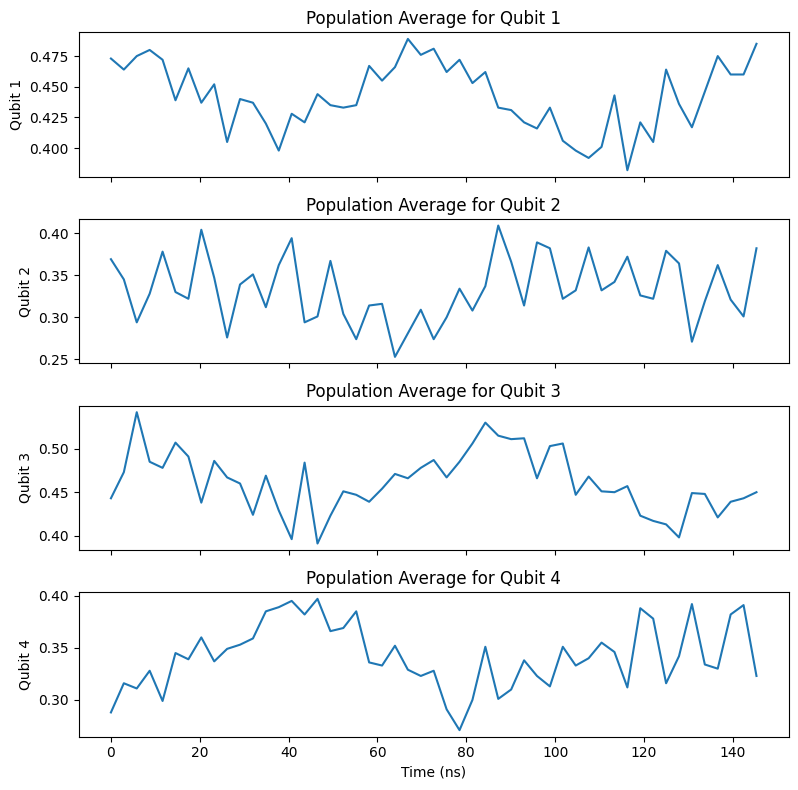

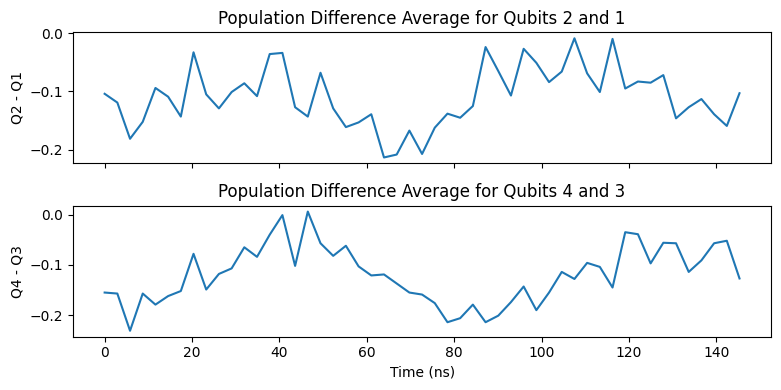

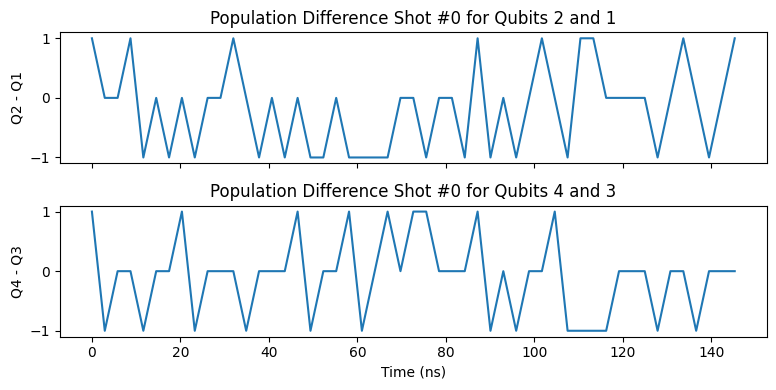

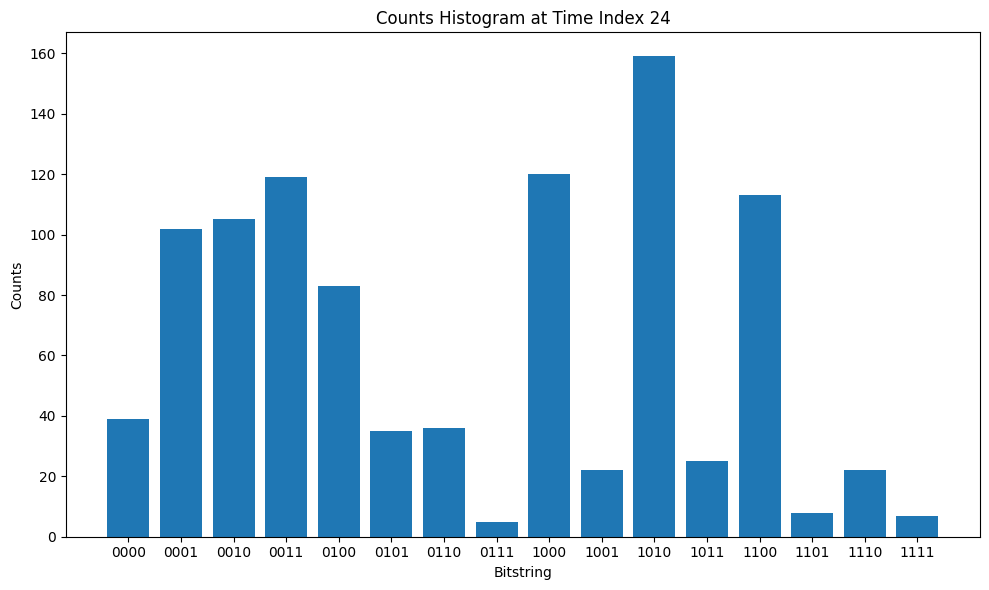

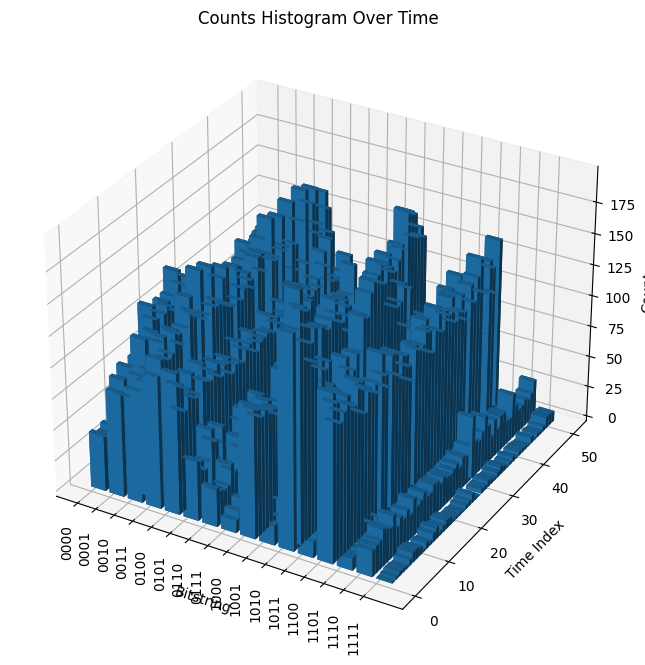

correcting for index 0 and index 2
correcting for index 0 and index 3
correcting for index 1 and index 2
correcting for index 1 and index 3


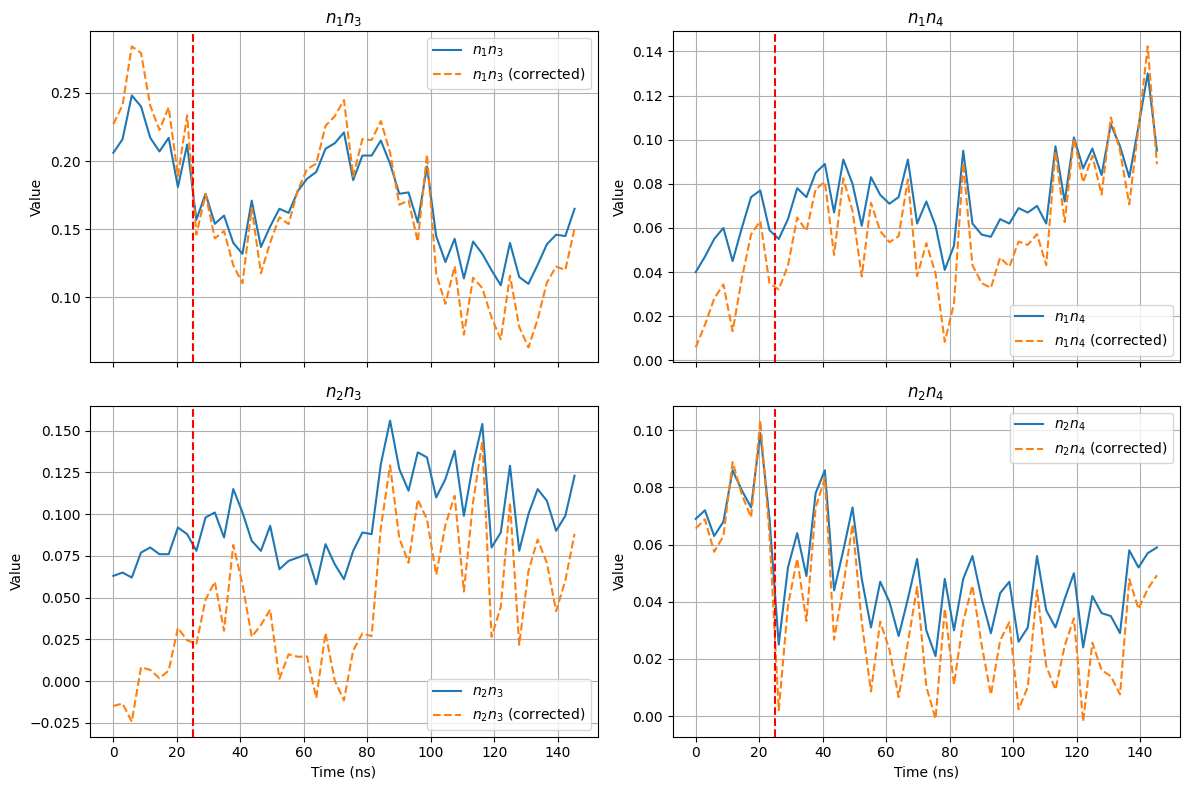

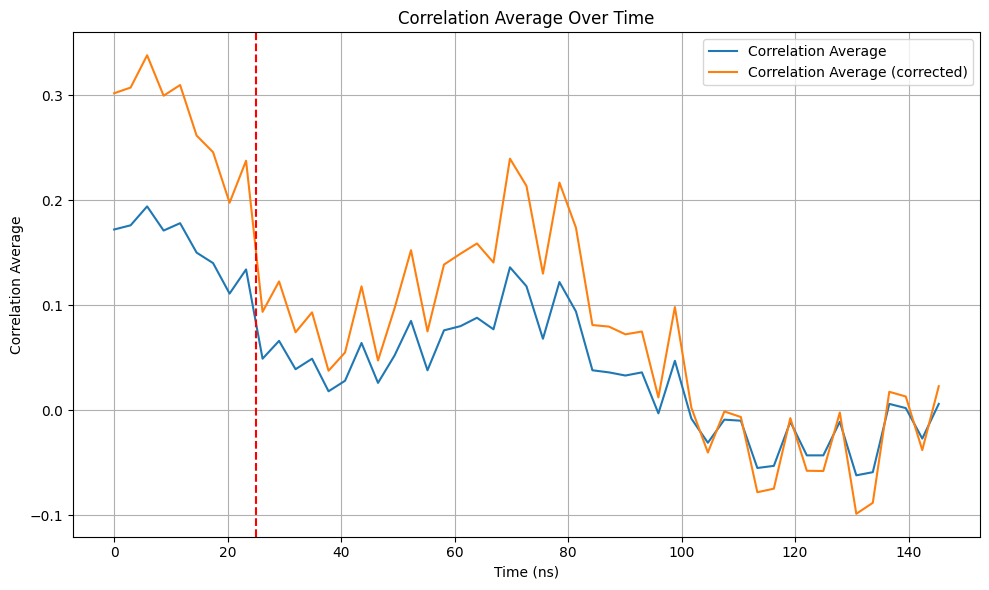

In [350]:
beamsplitter_time = 25

correlations_calibration_measurement.plot_population_average()
correlations_calibration_measurement.plot_population_difference_average()
correlations_calibration_measurement.plot_population_difference_shots(0)

counts_matrix = correlations_calibration_measurement.get_counts_matrix()

correlations_calibration_measurement.plot_counts_histogram_slice(24)
correlations_calibration_measurement.plot_counts_histogram()


correlations_calibration_measurement.plot_n_terms(both=True, beamsplitter_time=beamsplitter_time)

correlations_calibration_measurement.plot_correlation_average(both=True, beamsplitter_time=beamsplitter_time)


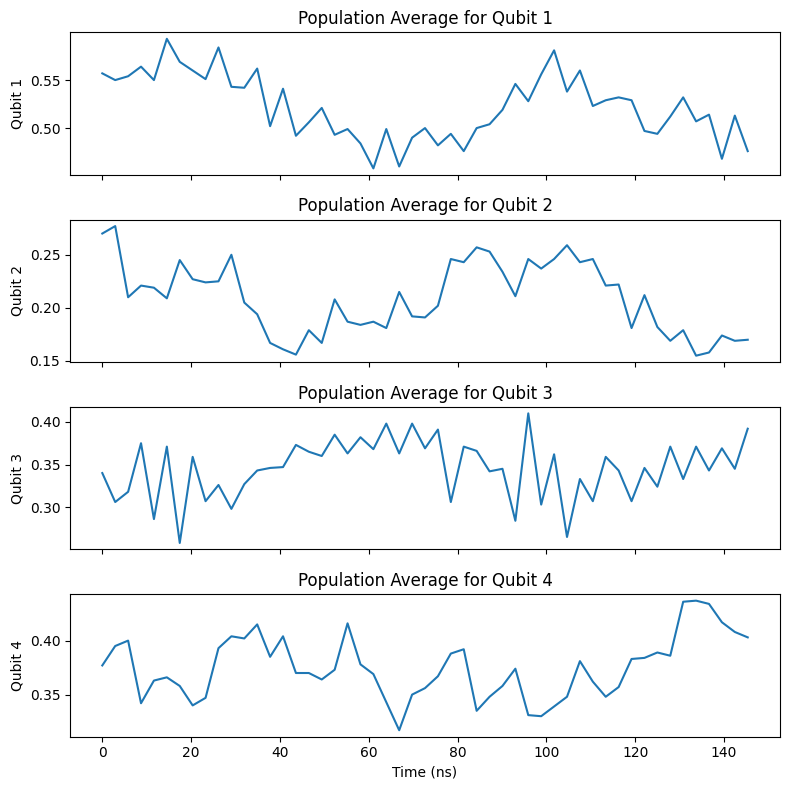

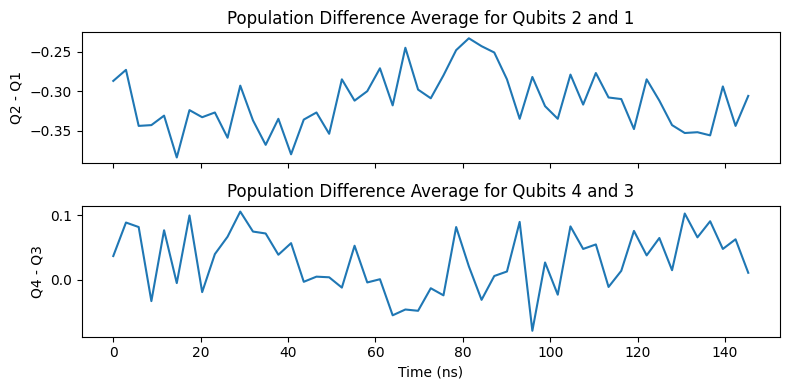

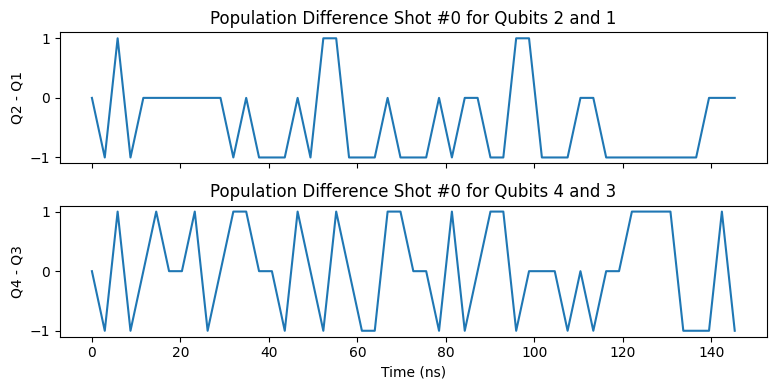

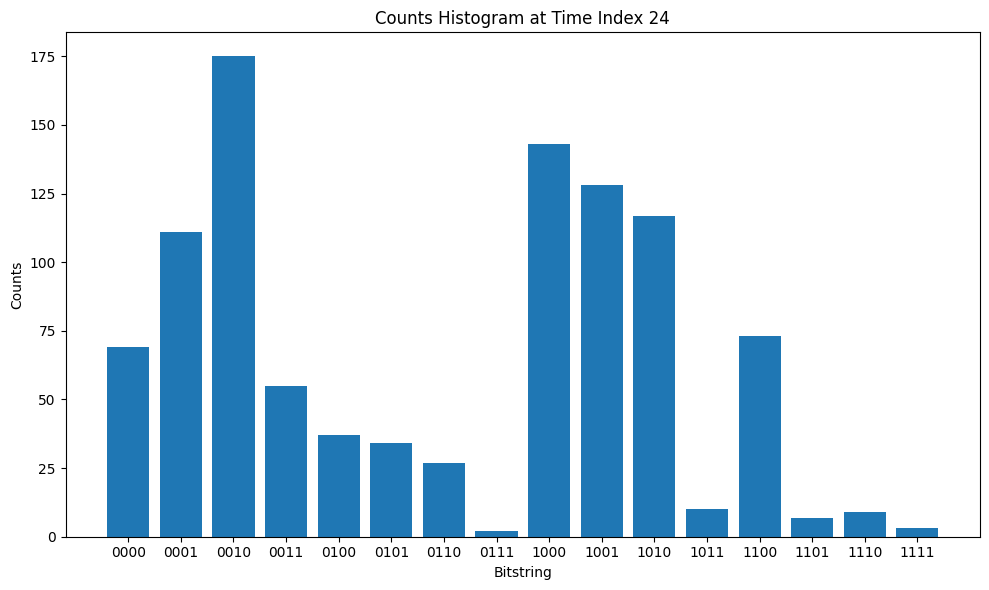

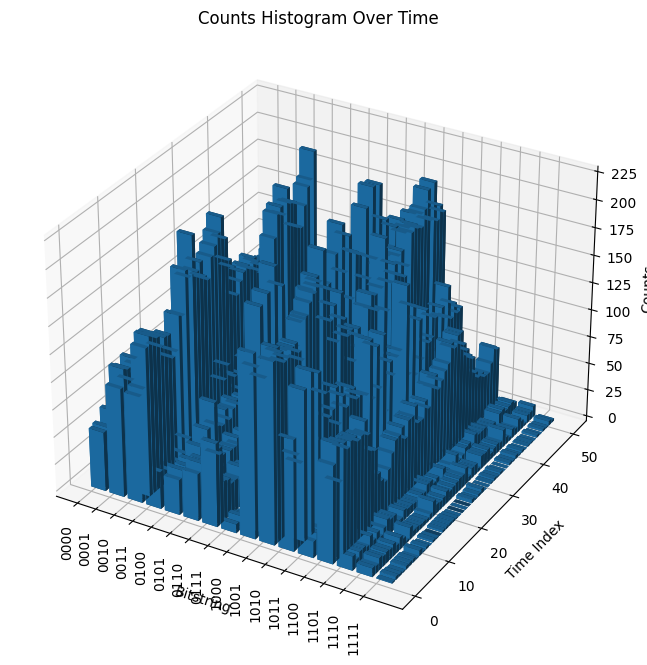

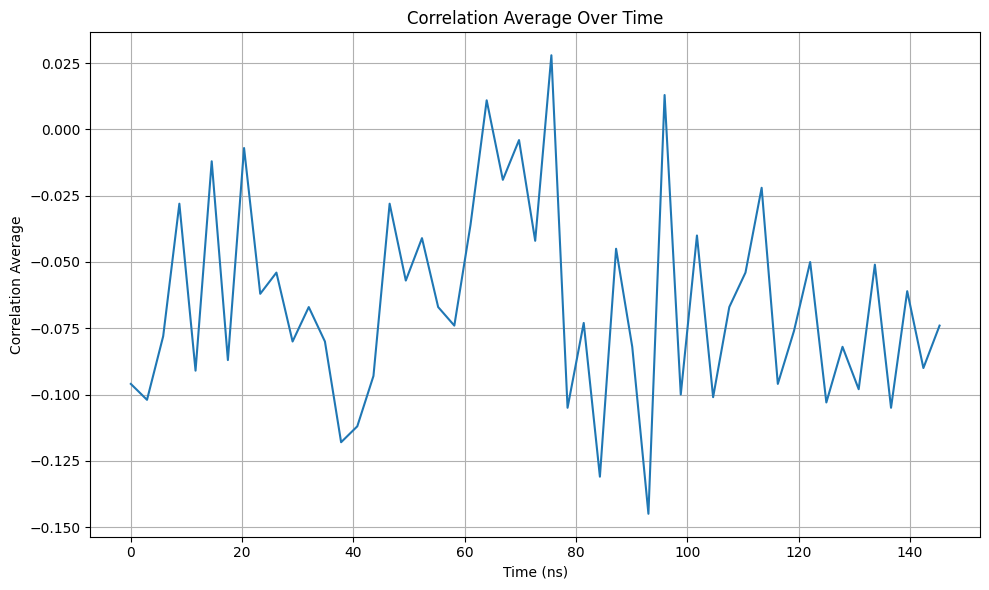

In [ ]:
negative_correlations_calibration_measurement.plot_population_average()
negative_correlations_calibration_measurement.plot_population_difference_average()
negative_correlations_calibration_measurement.plot_population_difference_shots(0)

counts_matrix = correlations_calibration_measurement.get_counts_matrix()

negative_correlations_calibration_measurement.plot_counts_histogram_slice(24)
negative_correlations_calibration_measurement.plot_counts_histogram()

negative_correlations_calibration_measurement.plot_correlation_average()

In [28]:
beamsplitter_time = 25


no_correlations_calibration_measurement.plot_population_average()
no_correlations_calibration_measurement.plot_population_difference_average()
no_correlations_calibration_measurement.plot_population_difference_shots(0)

counts_matrix = correlations_calibration_measurement.get_counts_matrix()

no_correlations_calibration_measurement.plot_counts_histogram_slice(24)
no_correlations_calibration_measurement.plot_counts_histogram()

no_correlations_calibration_measurement.plot_n_terms(both=True, beamsplitter_time=beamsplitter_time)

no_correlations_calibration_measurement.plot_correlation_average(both=True, beamsplitter_time=beamsplitter_time)




NameError: name 'no_correlations_calibration_measurement' is not defined

### Try offseting Q1-Q2 by Q3-Q4 since they have difference beamsplitter times

In [ ]:
importlib.reload(src_current_measurement);
from src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename


correlations_calibration_measurement = CurrentMeasurementCalibration(correlations_calibration_file, [0,1], [2,3], 
                                                                     singleshot_2Q_measurements=singleshot_2Q_measurements, time_offset=0)



no_correlations_calibration_measurement = CurrentMeasurementCalibration(no_correlations_calibration_file, [0,1], [2,3], 
                                                                     singleshot_2Q_measurements=singleshot_2Q_measurements, time_offset=0)


In [3]:
def J_to_beamsplitter_time(J):
    """
    Convert J (2pi MHz) to beamsplitter time in nanoseconds.
    """
    return np.pi/4/(J) / 1e6 * 1e9

def J_to_beamsplitter_time_samples(J):
    """
    Convert J (2pi MHz) to beamsplitter time in samples.
    """
    return np.pi/4/(J) / 1e6 * 1e9 * 16 / 2.32515*2

In [116]:
J_12 = 6.74
q1_q2_beamsplitter_time = J_to_beamsplitter_time(J_12)
q1_q2_beamsplitter_time_samples = J_to_beamsplitter_time_samples(J_12)
print(f'Q1-Q2 beamsplitter time for J={J_12} MHz: {q1_q2_beamsplitter_time:.2f} ns')
print(f'Q1-Q2 beamsplitter time in samples: {q1_q2_beamsplitter_time_samples:.2f} samples')

J_34 = 5.79
q3_q4_beamsplitter_time = J_to_beamsplitter_time(J_34)
q3_q4_beamsplitter_time_samples = J_to_beamsplitter_time_samples(J_34)
print(f'Q3-Q4 beamsplitter time for J={J_34} MHz: {q3_q4_beamsplitter_time:.2f} ns')
print(f'Q3-Q4 beamsplitter time in samples: {q3_q4_beamsplitter_time_samples:.2f} samples')

print(f'need to offset q1-q2 by {round(q3_q4_beamsplitter_time_samples - q1_q2_beamsplitter_time_samples)} samples')

Q1-Q2 beamsplitter time for J=6.74 MHz: 116.53 ns
Q1-Q2 beamsplitter time in samples: 1603.72 samples
Q3-Q4 beamsplitter time for J=5.79 MHz: 135.65 ns
Q3-Q4 beamsplitter time in samples: 1866.85 samples
need to offset q1-q2 by 263 samples


In [105]:
4.64/16

0.29

timestep before multiplication: 10.0 ns
timestep after multiplication: 2.9064375 ns
(4, 51, 10000)
after padding
(4, 52, 10000)
time step: 2.9064375 ns


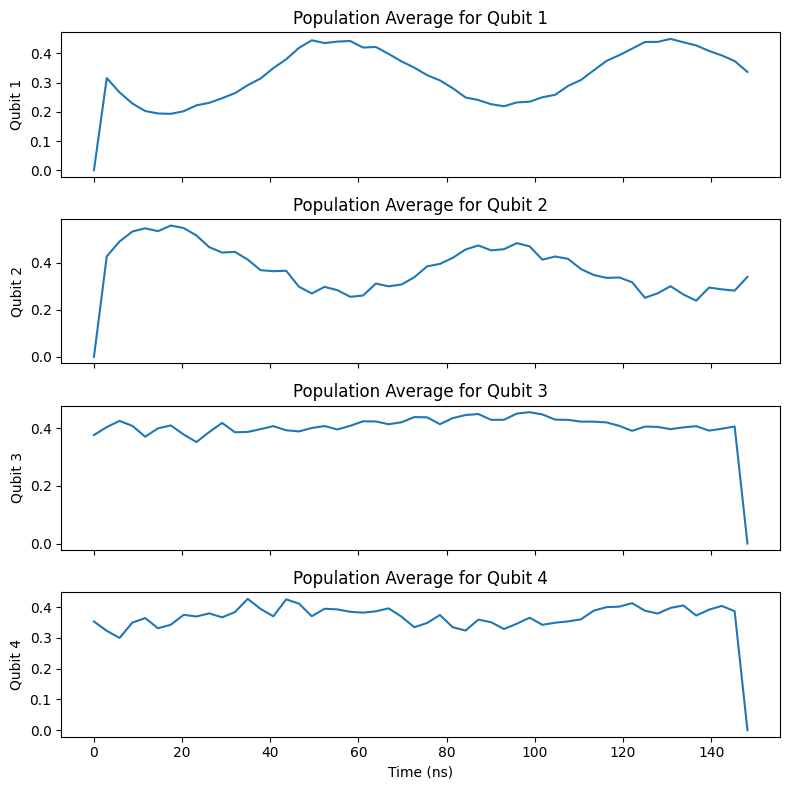

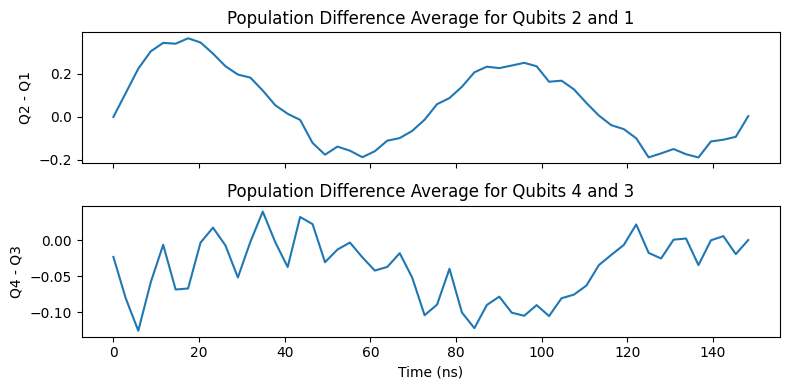

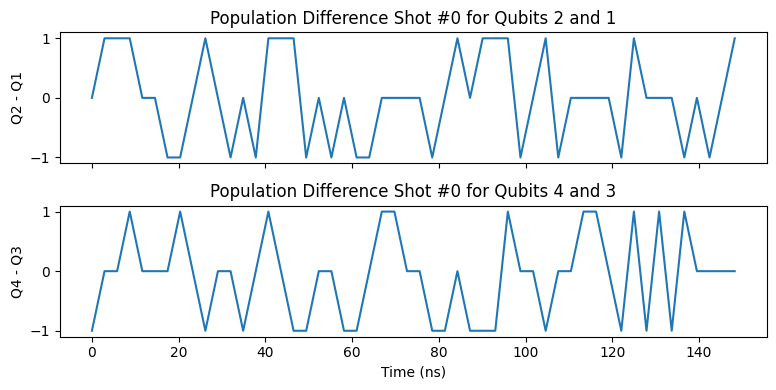

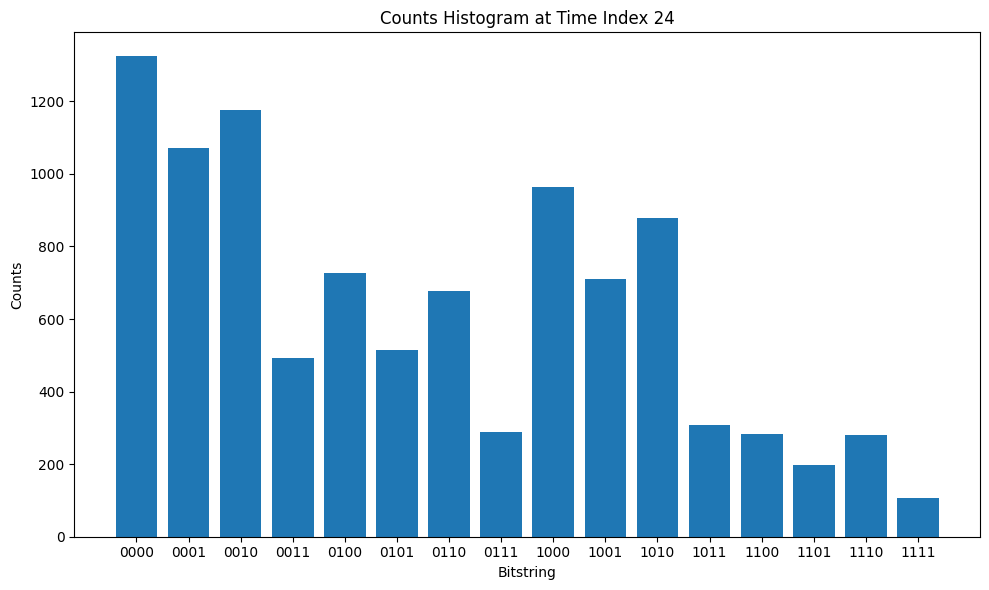

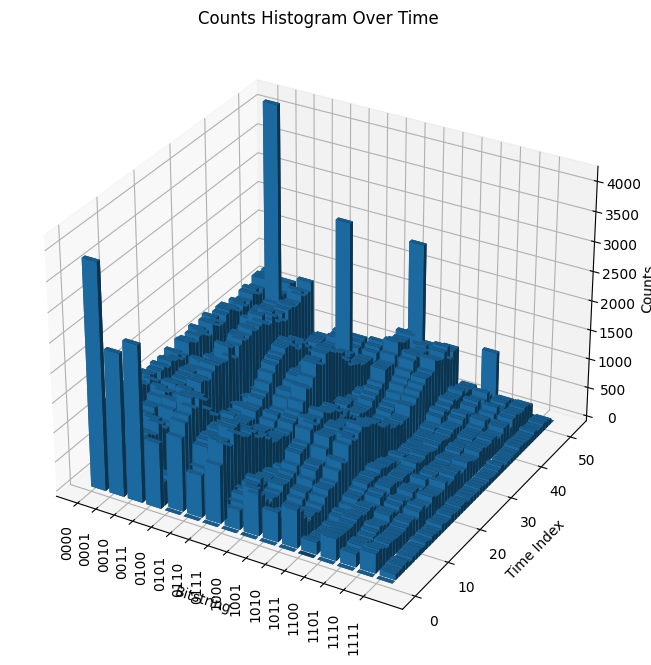

correcting for index 0 and index 2
correcting for index 0 and index 3
correcting for index 1 and index 2
correcting for index 1 and index 3


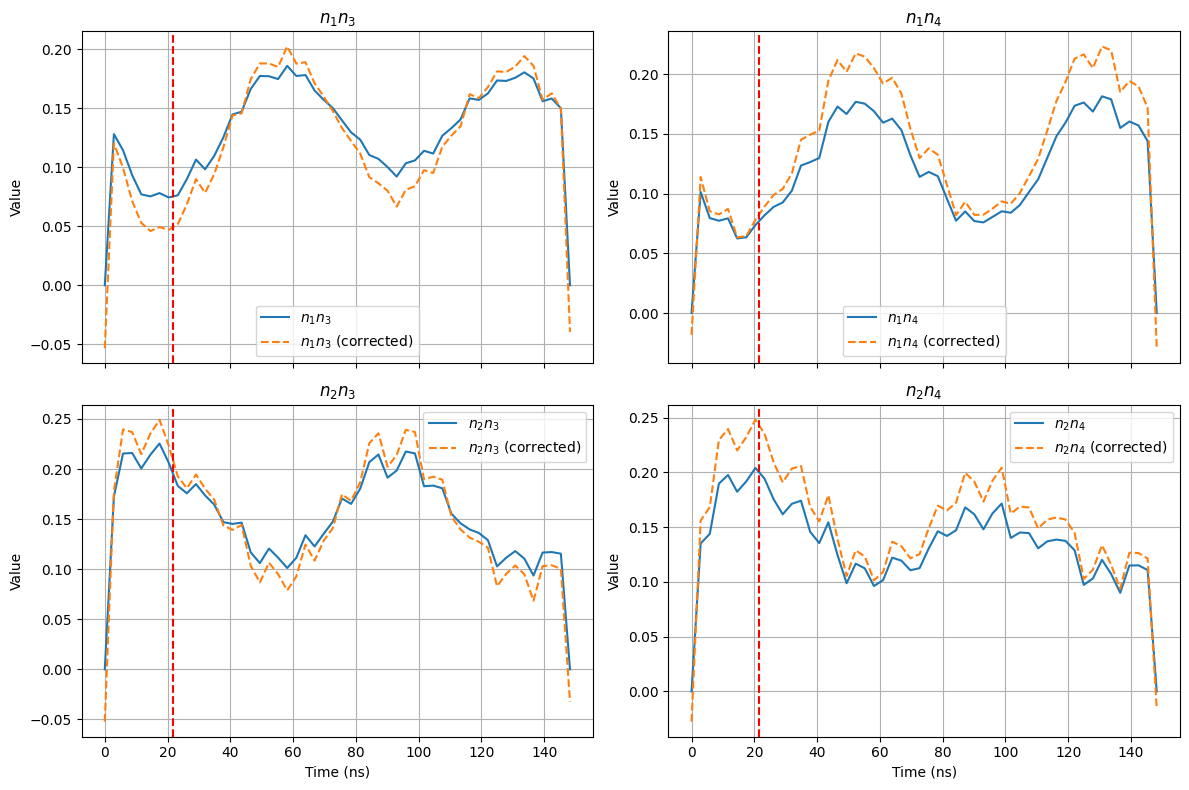

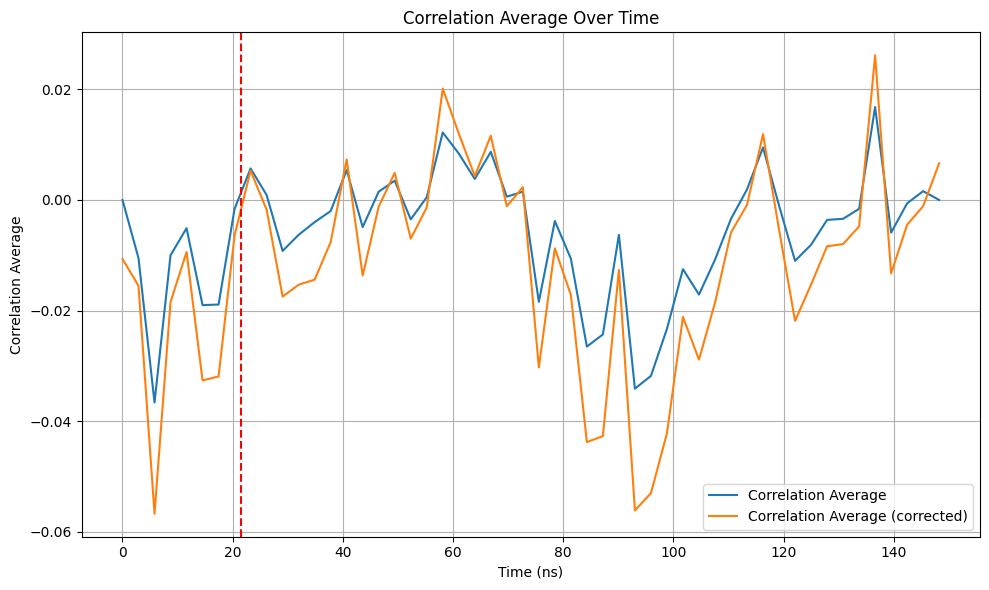

In [106]:
beamsplitter_time = 21.6

times = correlations_calibration_measurement.get_times()
print(f'time step: {times[1] - times[0]} ns')

correlations_calibration_measurement.plot_population_average()
correlations_calibration_measurement.plot_population_difference_average()
correlations_calibration_measurement.plot_population_difference_shots(0)

counts_matrix = correlations_calibration_measurement.get_counts_matrix()

correlations_calibration_measurement.plot_counts_histogram_slice(24)
correlations_calibration_measurement.plot_counts_histogram()


correlations_calibration_measurement.plot_n_terms(both=True, beamsplitter_time=beamsplitter_time)

correlations_calibration_measurement.plot_correlation_average(both=True, beamsplitter_time=beamsplitter_time)


timestep before multiplication: 10.0 ns
timestep after multiplication: 2.9064375 ns
(4, 51, 10000)
after padding
(4, 52, 10000)
time step: 2.9064375 ns
timestep before multiplication: 10.0 ns
timestep after multiplication: 2.9064375 ns
(4, 51, 10000)
after padding
(4, 52, 10000)


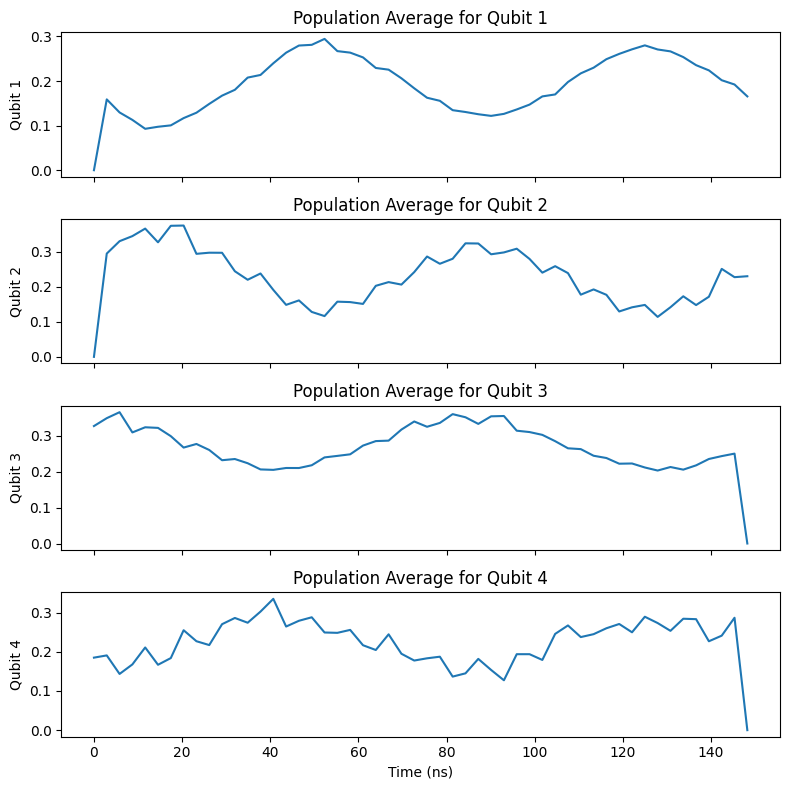

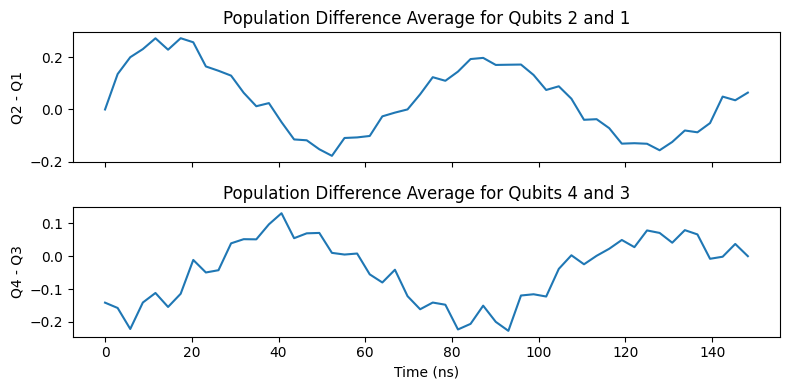

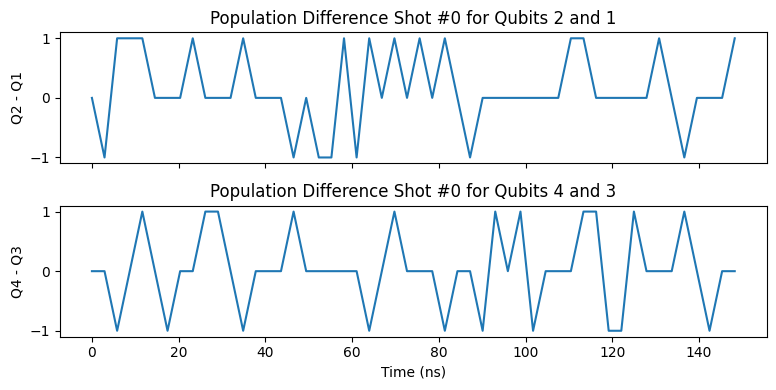

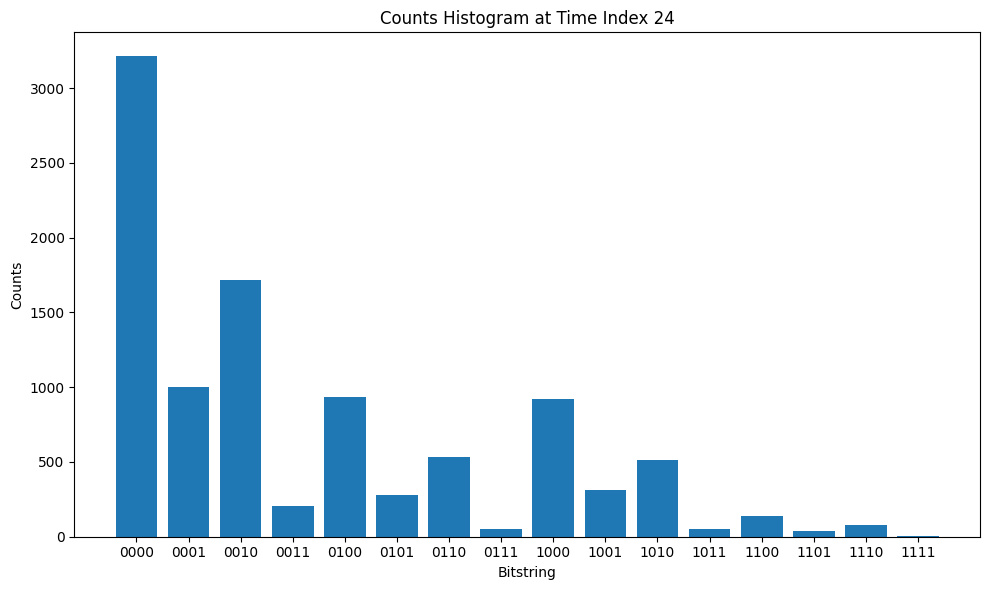

c:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1\current_measurements\src_current_measurement.py:390: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  ax.set_xticklabels(bitstrings, rotation=90)


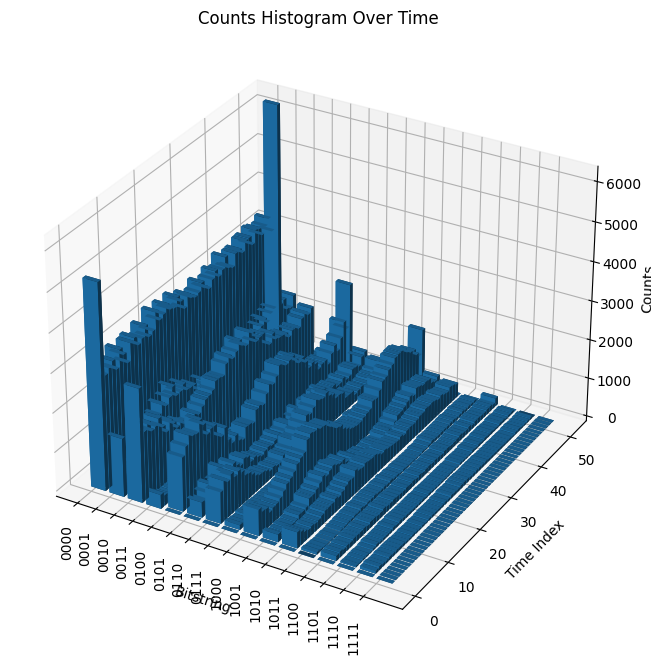

correcting for index 0 and index 2
correcting for index 0 and index 3
correcting for index 1 and index 2
correcting for index 1 and index 3


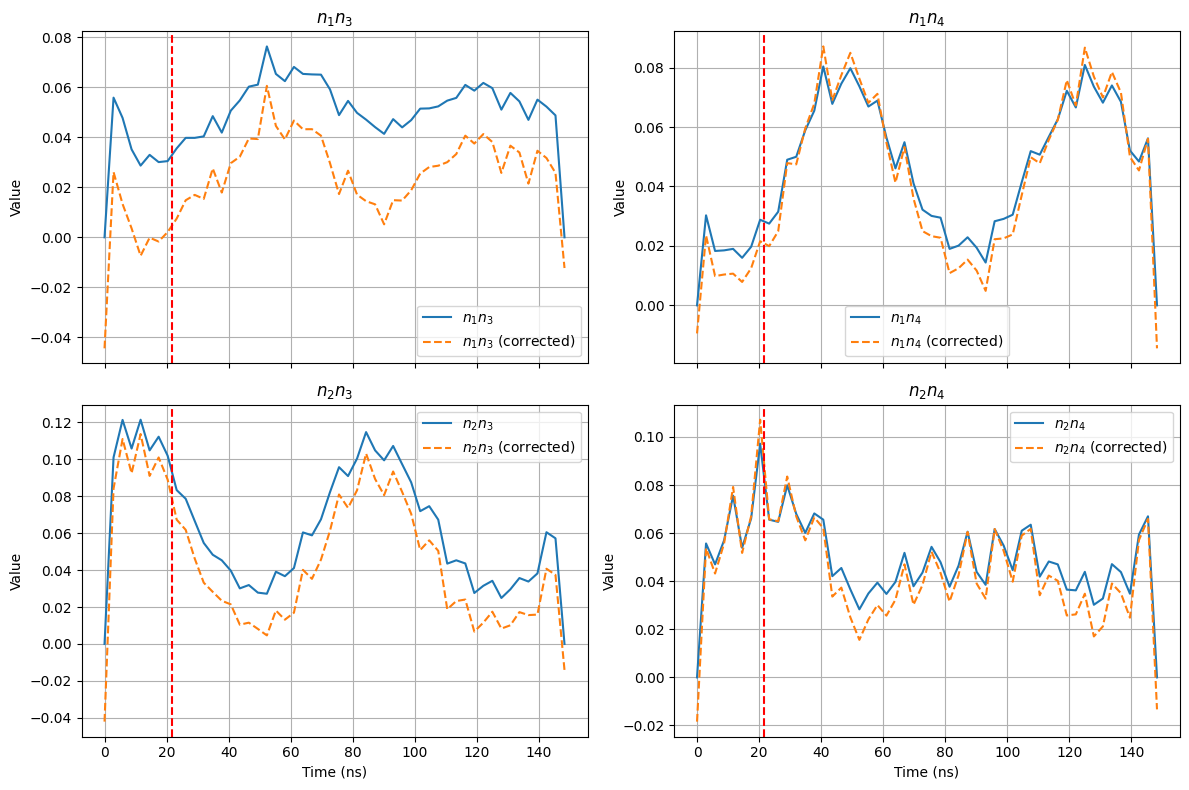

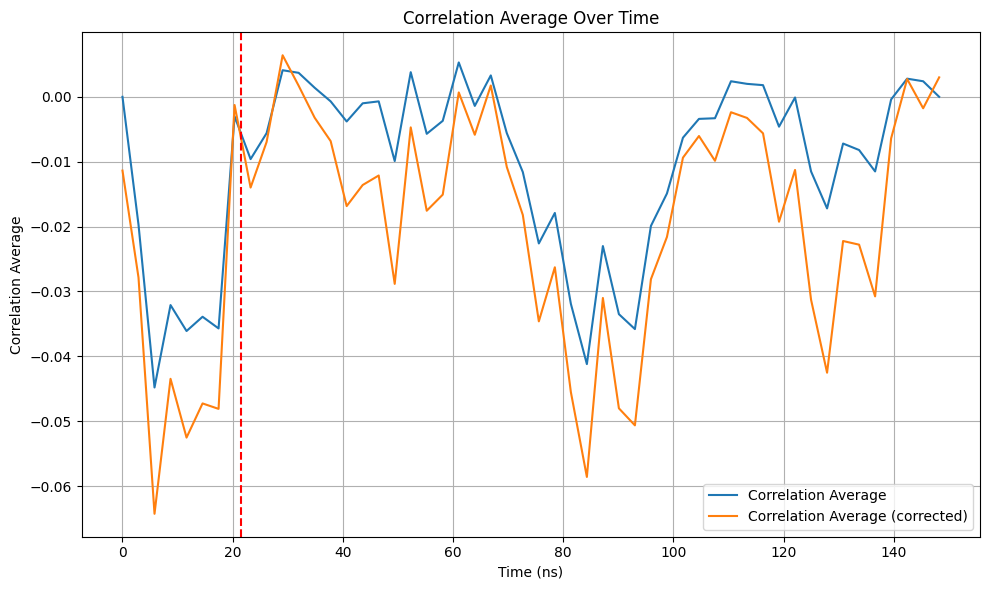

In [110]:
beamsplitter_time = 21.6

times = correlations_calibration_measurement.get_times()
print(f'time step: {times[1] - times[0]} ns')

no_correlations_calibration_measurement.plot_population_average()
no_correlations_calibration_measurement.plot_population_difference_average()
no_correlations_calibration_measurement.plot_population_difference_shots(0)

no_counts_matrix = correlations_calibration_measurement.get_counts_matrix()

no_correlations_calibration_measurement.plot_counts_histogram_slice(24)
no_correlations_calibration_measurement.plot_counts_histogram()


no_correlations_calibration_measurement.plot_n_terms(both=True, beamsplitter_time=beamsplitter_time)

no_correlations_calibration_measurement.plot_correlation_average(both=True, beamsplitter_time=beamsplitter_time)


# 3. Fit Data to Simulation

[[0.9822 0.0752]
 [0.0178 0.9248]]


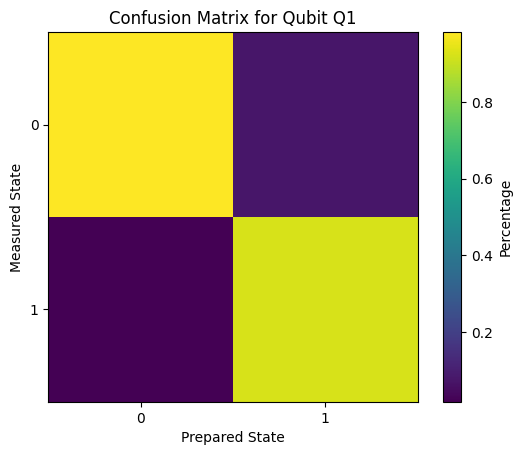

[[0.9252 0.1582]
 [0.0748 0.8418]]


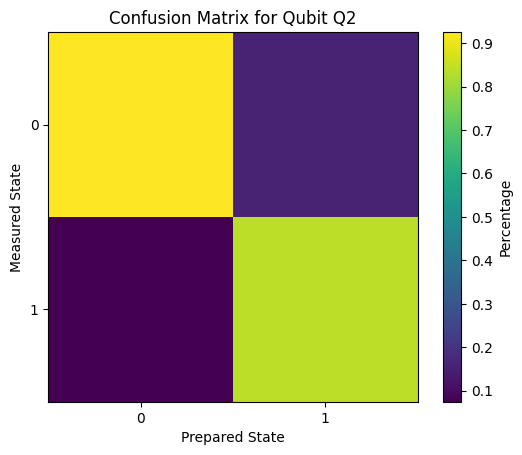

[[0.951  0.1118]
 [0.049  0.8882]]


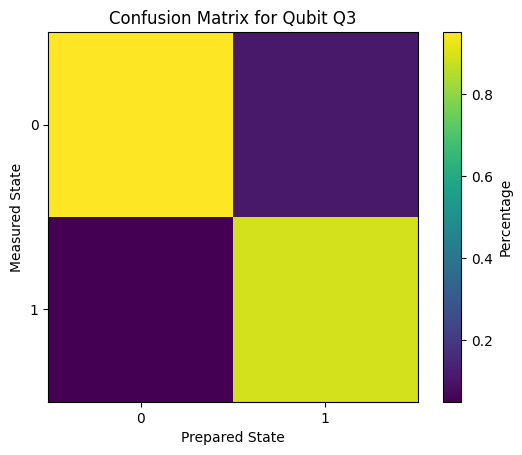

[[0.9578 0.156 ]
 [0.0422 0.844 ]]


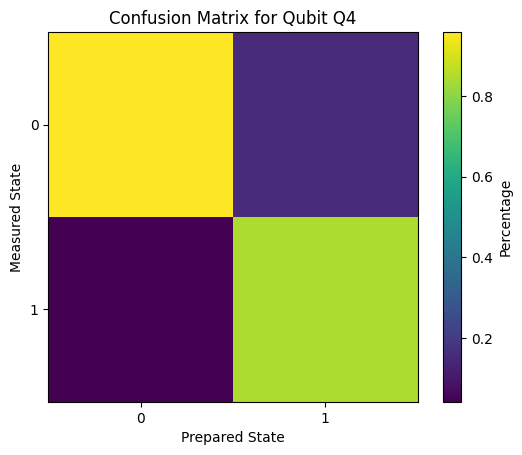

[[0.92   0.0934 0.0634 0.0096]
 [0.0572 0.8864 0.0038 0.0814]
 [0.0216 0.0012 0.87   0.0806]
 [0.0012 0.019  0.0628 0.8284]]


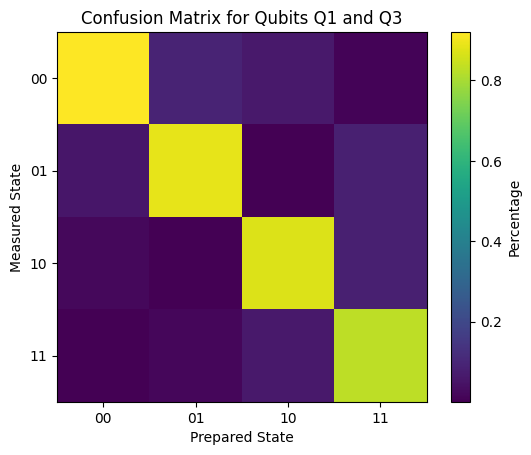

[[0.9234 0.1668 0.076  0.009 ]
 [0.053  0.8092 0.0036 0.0538]
 [0.021  0.0038 0.8756 0.1598]
 [0.0026 0.0202 0.0448 0.7774]]


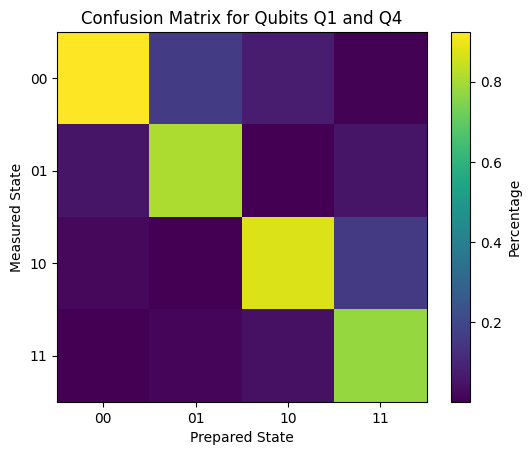

[[0.8656 0.0852 0.1548 0.0368]
 [0.0634 0.7194 0.01   0.1074]
 [0.0632 0.0206 0.778  0.2376]
 [0.0078 0.1748 0.0572 0.6182]]


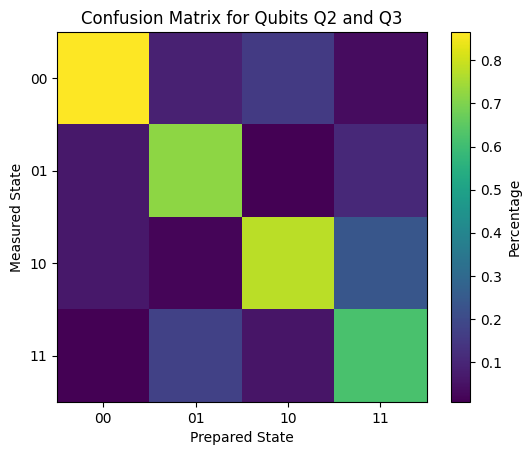

[[0.868  0.1714 0.1404 0.0302]
 [0.0524 0.7352 0.008  0.1268]
 [0.0734 0.0184 0.8068 0.1812]
 [0.0062 0.075  0.0448 0.6618]]


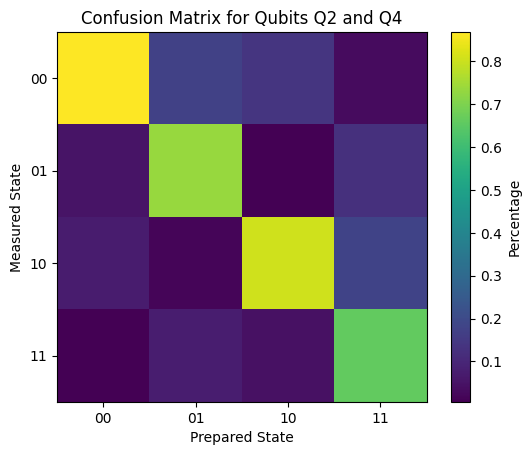

In [9]:
### load in singleshot data


importlib.reload(src.src_singleshot_measurement);
from src.src_singleshot_measurement import Singleshot_2Q_Measurement, Singleshot_1Q_Measurement, generate_singleshot_2Q_filename, generate_singleshot_1Q_filename


singleshot_filenames = {}
# single qubit
singleshot_filenames[0] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '10', '45')
singleshot_filenames[1] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '11', '22')
singleshot_filenames[2] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '11', '44')
singleshot_filenames[3] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '12', '02')

# two qubits
singleshot_filenames[(0, 2)] = generate_singleshot_2Q_filename('2025', '07', '28', '11', '47', '46')
singleshot_filenames[(0, 3)] = generate_singleshot_2Q_filename('2025', '07', '28', '11', '54', '03')
singleshot_filenames[(1, 2)] = generate_singleshot_2Q_filename('2025', '07', '28', '12', '01', '41')
singleshot_filenames[(1, 3)] = generate_singleshot_2Q_filename('2025', '07', '28', '12', '03', '50')

singleshot_measurements = {}
for key in singleshot_filenames:

    if isinstance(key, tuple) and len(key) == 2:
        pair = key

        filename = singleshot_filenames[pair]
        singleshot_measurement = Singleshot_2Q_Measurement(filename, f'Q{pair[0]+1}', f'Q{pair[1]+1}')
        singleshot_measurements[pair] = singleshot_measurement
    elif isinstance(key, int):
        filename = singleshot_filenames[key]
        singleshot_measurement = Singleshot_1Q_Measurement(filename, f'Q{key+1}')
        singleshot_measurements[key] = singleshot_measurement

    print(singleshot_measurement.get_confusion_matrix())
    singleshot_measurements[key].plot_confusion_matrix()
    

In [147]:
# load in calibration measurement data

importlib.reload(src.src_current_measurement);
from src.src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename, generate_ramp_beamsplitter_correlations_filename
importlib.reload(src.src_current_measurement_simulations);
from src.src_current_measurement_simulations import CurrentMeasurementSimulation

# assume readout indices are 0,1 and 2,3 for all of these

time_offset = [0, 0, -15, -15 ]
time_offset = [0, 0, 4, 4]
time_offset = 0 

readout_indices_1 = [0,1]
readout_indices_2 = [2,3]

state_to_filename = {}

# 7/23/25
# # correlations
# state_to_filename['CD'] = generate_current_calibration_filename('2025', '07', '23', '13', '11', '30') 
# state_to_filename['CD'] = generate_current_calibration_filename('2025', '07', '23', '13', '51', '55') # more points

# # larger correlations
# state_to_filename['BD'] = generate_current_calibration_filename('2025', '07', '23', '13', '06', '46')
# state_to_filename['BD'] = generate_current_calibration_filename('2025', '07', '23', '13', '29', '20') # more points

# # negative correlations
# state_to_filename['BC'] = generate_current_calibration_filename('2025', '07', '23', '13', '15', '41') 
# state_to_filename['BC'] = generate_current_calibration_filename('2025', '07', '23', '14', '00', '16') # more points

# # no correlations
# state_to_filename['D'] = generate_current_calibration_filename('2025', '07', '23', '13', '02', '17') 
# state_to_filename['D'] = generate_current_calibration_filename('2025', '07', '23', '14', '14', '27') # more points 

# 7/24/25
# correlations
# state_to_filename['CD'] = generate_current_calibration_filename('2025', '07', '24', '17', '12', '14') 

# # # larger correlations
# state_to_filename['BD'] = generate_current_calibration_filename('2025', '07', '24', '17', '15', '28')

# # # negative correlations
# state_to_filename['BC'] = generate_current_calibration_filename('2025', '07', '24', '17', '24', '43') 

# # # no correlations
# state_to_filename['D'] = generate_current_calibration_filename('2025', '07', '24', '17', '19', '59') 

# 7/25/25
# # correlations
# state_to_filename['CD'] = generate_current_calibration_filename('2025', '07', '26', '00', '23', '05') 

# # # larger correlations
# state_to_filename['BD'] = generate_current_calibration_filename('2025', '07', '26', '00', '44', '10')

# # # negative correlations
# state_to_filename['BC'] = generate_current_calibration_filename('2025', '07', '26', '00', '30', '03') 

# # # no correlations
# state_to_filename['D'] = generate_current_calibration_filename('2025', '07', '26', '00', '49', '32') 

# 7/27/25
# # correlations
# state_to_filename['CD'] = generate_current_calibration_filename('2025', '07', '27', '11', '48', '03')

# # # larger correlations
# state_to_filename['BD'] = generate_current_calibration_filename('2025', '07', '27', '11', '48', '03')

# # # negative correlations
# state_to_filename['BC'] = generate_current_calibration_filename('2025', '07', '27', '11', '42', '41') 

# # # no correlations
# state_to_filename['D'] = generate_current_calibration_filename('2025', '07', '27', '11', '54', '13') 



# 7/28/25
# correlations
# state_to_filename['CD'] = generate_current_calibration_filename('2025', '07', '28', '11', '11', '52')

# # # larger correlations
# state_to_filename['BD'] = generate_current_calibration_filename('2025', '07', '28', '11', '18', '32')

# # # negative correlations
# state_to_filename['BC'] = generate_current_calibration_filename('2025', '07', '28', '11', '23', '35') 

# # # no correlations
# state_to_filename['D'] = generate_current_calibration_filename('2025', '07', '28', '11', '30', '43') 
# state_to_filename['D'] = generate_current_calibration_filename('2025', '07', '28', '11', '30', '43') 


# state_to_filename['C'] = generate_current_calibration_filename('2025', '07', '28', '18', '05', '43') 
# state_to_filename['B'] = generate_current_calibration_filename('2025', '07', '28', '18', '02', '17') 
# state_to_filename['A'] = generate_current_calibration_filename('2025', '07', '28', '17', '58', '11') 


# 8/18/25
# correlations
state_to_filename['CD'] = generate_ramp_beamsplitter_correlations_filename('2025', '08', '18', '19', '11', '00')
state_to_filename['D'] = generate_ramp_beamsplitter_correlations_filename('2025', '08', '18', '22', '08', '36')




state_to_calibration_measurement = {}
post_select = False

for state in state_to_filename:
    filename = state_to_filename[state]
    state_to_calibration_measurement[state] = CurrentMeasurementCalibration(filename, readout_indices_1, readout_indices_2, singleshot_measurements=singleshot_measurements, post_select=post_select, particle_number=len(state), time_offset=time_offset)
    

In [127]:
def cost_function(data, simulation):
    """
    Calculate the cost function as the sum squared error between the measured and simulated N-terms.
    """
    return np.sum((data - simulation) ** 2)

Processing state D with beamsplitter time 18.55 ns
timestep before multiplication: 4.0 ns
timestep after multiplication: 1.162575 ns
(4, 201, 10000)
after padding
(4, 201, 10000)


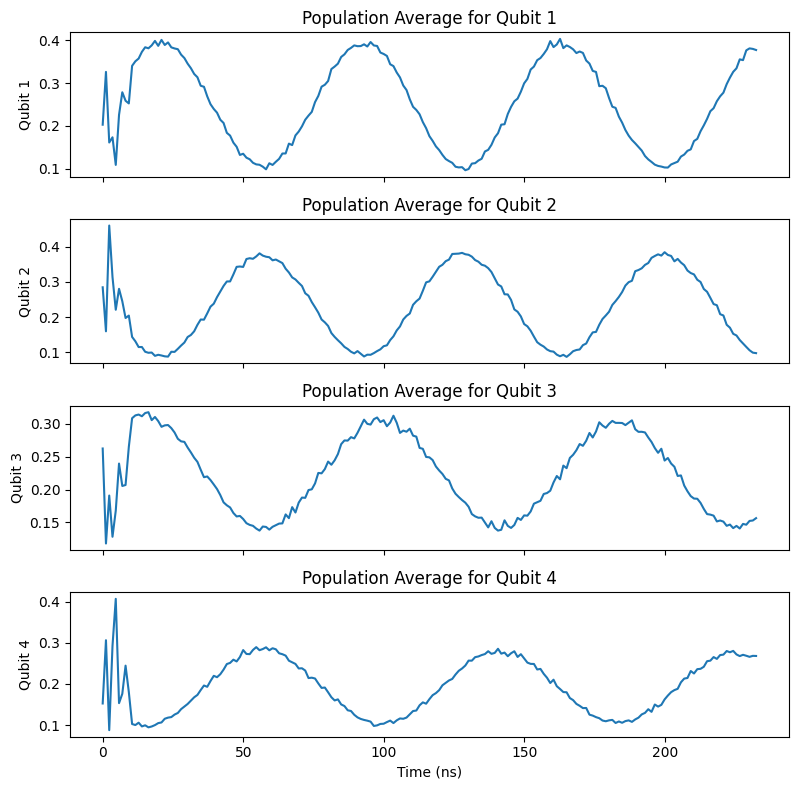

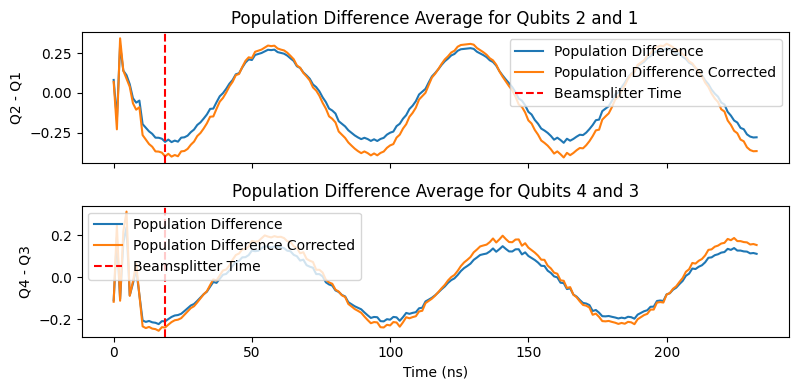

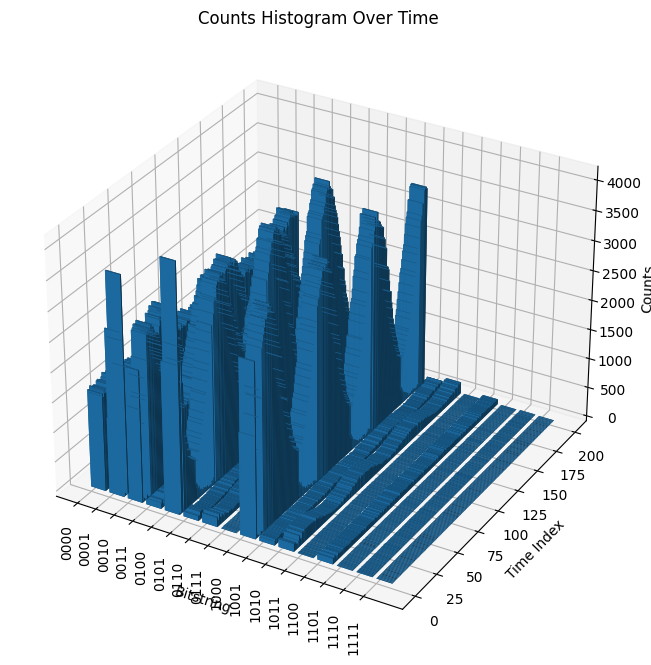

correcting for index 0 and index 2
correcting for index 0 and index 3
correcting for index 1 and index 2
correcting for index 1 and index 3


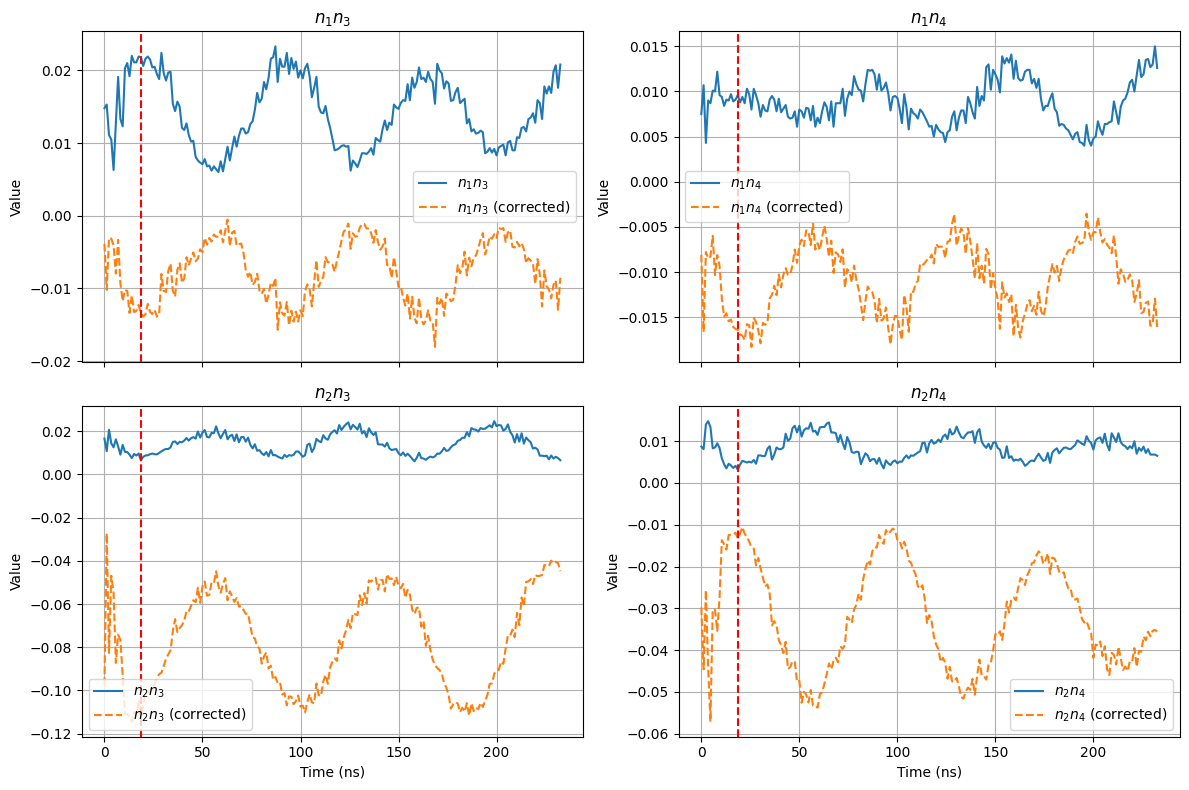

(2, 201)
(201,)


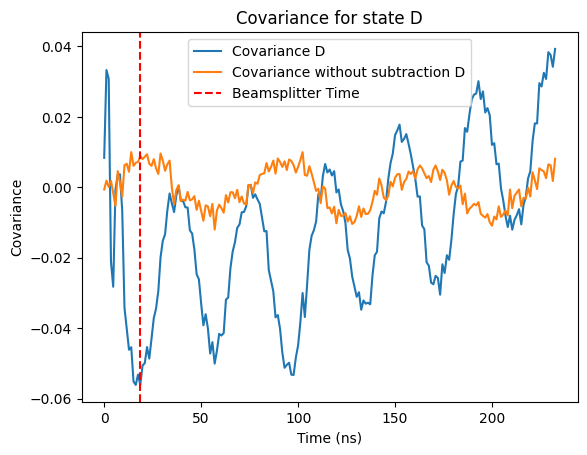

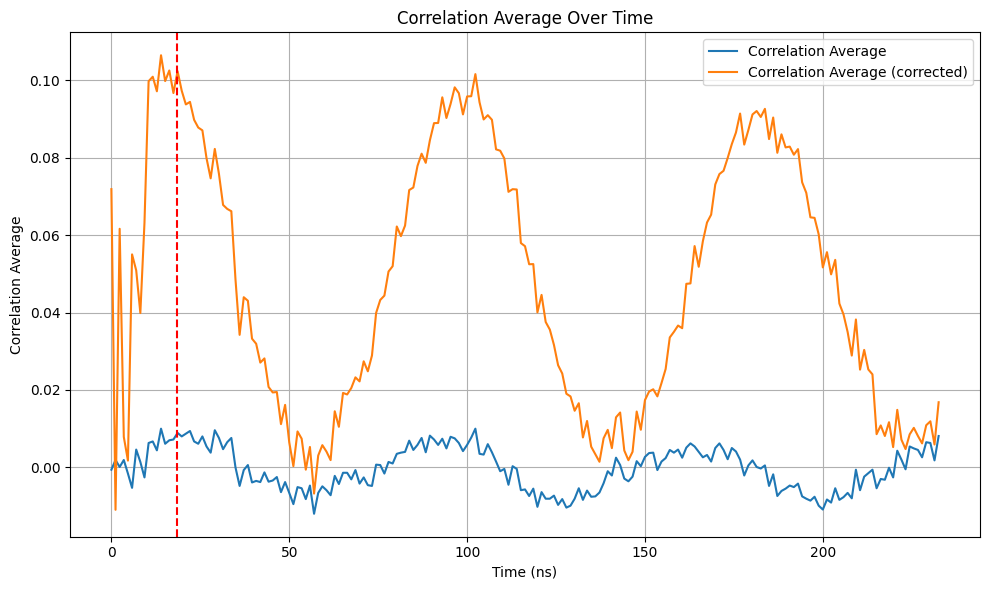

In [148]:
plot_data = True
# plot_data = False
plot_states = None
plot_states = ['D']  

J = 6.74 * 2 * np.pi
beamsplitter_time = J_to_beamsplitter_time(J)

if plot_data:

    for state in state_to_calibration_measurement:

        if plot_states is not None and state not in plot_states:
            continue

        print(f"Processing state {state} with beamsplitter time {beamsplitter_time:.2f} ns")
        # state_to_calibration_measurement[state].plot_population_average(both=True, plot_sum=True)
        state_to_calibration_measurement[state].plot_population_average(plot_sum=False)
        state_to_calibration_measurement[state].plot_population_difference_average(both=True, beamsplitter_time=beamsplitter_time)

        state_to_calibration_measurement[state].plot_counts_histogram()

        state_to_calibration_measurement[state].plot_n_terms(both=True, beamsplitter_time=beamsplitter_time)

        population_difference = state_to_calibration_measurement[state].get_population_difference_average()
        print(population_difference.shape)

        correlation_average = state_to_calibration_measurement[state].get_correlation_average()
        print(correlation_average.shape)


        covariance = correlation_average - population_difference[0] * population_difference[1]
        plt.plot(state_to_calibration_measurement[state].get_times(), covariance, label=f'Covariance {state}')
        plt.plot(state_to_calibration_measurement[state].get_times(), correlation_average, label=f'Covariance without subtraction {state}')
        plt.axvline(x=beamsplitter_time, color='r', linestyle='--', label='Beamsplitter Time')
        plt.xlabel('Time (ns)')
        plt.ylabel('Covariance')
        plt.title(f'Covariance for state {state}')
        plt.legend()
        plt.show()

        state_to_calibration_measurement[state].plot_correlation_average(both=True, beamsplitter_time=beamsplitter_time)

        print()

### 3.1 Fit n terms

In [176]:
state = 'CD'
# state = 'BD'
# state = 'BC'
# state = 'D'
# state = 'B'

measurement = state_to_calibration_measurement[state]

# order will be n13, n14, n23, n24

readout_pair_1 = [0, 1]  
readout_pair_2 = [2, 3]  

n_terms_data = []
for i in readout_pair_1:
    for j in readout_pair_2:
        # n_terms_data.append(measurement.get_n_term(i, j))
        n_terms_data.append(measurement.get_n_term_corrected(i, j))


n_terms_data = np.array(n_terms_data)
current_correlation_data = n_terms_data[0,:] - n_terms_data[1,:] - n_terms_data[2,:] + n_terms_data[3,:]
print("N-Terms Data Shape:", n_terms_data.shape)

correcting for index 0 and index 2
correcting for index 0 and index 3
correcting for index 1 and index 2
correcting for index 1 and index 3
N-Terms Data Shape: (4, 281)


In [177]:
def create_psi0_with_angles(psi0, current_measurement_simulation, num_levels, num_qubits, num_particles, angles, bitstring):
    """
    Create a psi0 string with given angles and bitstring.
    If bitstring is None, it will be generated based on num_particles.
    """

    if bitstring is not None:

        if len(bitstring) != num_qubits:
            raise ValueError(f"psi0_bitstring must have length {num_qubits}, got {len(bitstring)}.")
        if bitstring.count('1') != num_particles:
            raise ValueError(f"psi0_bitstring must have exactly {num_particles} '1's, got {bitstring.count('1')}.")

        if isinstance(psi0, int):
            eigenstate_index = psi0
            one_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[1]
            two_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[2]

            # try prepare |0001> but actually get |0>|0>|theta_1, phi_1>|theta_2, phi_2>
            # |theta_i, phi_i> = cos(theta_i/2) |0> + exp(i*phi_i) sin(theta_i/2) |1>

            # |0000> -> vacuum state
            # |0001> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-1]
            # |0010> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-2]
            # |0011> -> current_measurement_simulation.get_particle_number_to_eigenstate()[2][-1]

            theta_1, phi_1, theta_2, phi_2 = angles

            

            prepared_state = 0

            if num_particles == 2:

                # find indices of two 1's in psi0_bitstring
                indices = [i for i in range(len(bitstring)) if bitstring[i] == '1']

                index_1, index_2 = indices
                negative_index_1 = -(num_qubits - index_1)
                negative_index_2 = -(num_qubits - index_2)


                prepared_state += np.cos(theta_1/2)*np.cos(theta_2/2) * qt.basis([num_levels] * num_qubits, [0, 0, 0, 0])  # |0000> 
                prepared_state += np.cos(theta_1/2)*np.sin(theta_2/2) * np.exp(1j*phi_2) * one_particle_eigenstates[negative_index_1]  # |0001> 
                prepared_state += np.sin(theta_1/2)*np.cos(theta_2/2) * np.exp(1j*phi_1) * one_particle_eigenstates[negative_index_2]  # |0010> 
                prepared_state += np.sin(theta_1/2)*np.sin(theta_2/2) * np.exp(1j*(phi_1 + phi_2)) * two_particle_eigenstates[eigenstate_index]  # |0011> 

                # print(f'first single particle state index: {negative_index_2}')
                # print(f'second single particle state index: {negative_index_1}')
                # print(f'two particle state index: {eigenstate_index}')

            else:
                eigenstate_index = psi0
                one_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[1]
                two_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[2]

                # try prepare |0001> but actually get |0>|0>|0>|theta, phi>
                # |theta_i, phi_i> = cos(theta_i/2) |0> + exp(i*phi_i) sin(theta_i/2) |1>

                # |0000> -> vacuum state
                # |0001> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-1]

                theta, phi, _, _ = angles

                prepared_state = 0
                prepared_state += np.cos(theta/2) * qt.basis([num_levels] * num_qubits, [0, 0, 0, 0])  # |0000> 
                prepared_state += np.sin(theta/2) * np.exp(1j*phi) * one_particle_eigenstates[eigenstate_index]  # |0001> 


        else:
            raise ValueError("psi0 must be an integer index if psi0_angles is provided.")
    else:
        raise ValueError("If psi0_angles is provided, psi0_bitstring must also be provided.")
    
    return prepared_state

In [178]:
def add_phase(initial_state, number_operators, pair_1, pair_2, phase_1, phase_2):
    ### modify initial state, manual for now


    # print(f'initial state before: {initial_state}')

    number_operators = number_operators
    phase_matrix = 1j*phase_1/2*(number_operators[pair_1[1]] - number_operators[pair_1[0]])
    phase_matrix += 1j*phase_2/2*(number_operators[pair_2[1]] - number_operators[pair_2[0]])

    

    phase_unitary = phase_matrix.expm()

    initial_state = phase_unitary * initial_state

    # print(f'initial state after: {initial_state}')

    rho = initial_state * initial_state.dag()
    rho_reduced = qt.ptrace(rho, [0, 1])

    # print(f'q1-q2 density matrix: {rho_reduced}')

    a_1 = qt.tensor(qt.destroy(num_levels), qt.qeye(num_levels))
    a_2 = qt.tensor(qt.qeye(num_levels), qt.destroy(num_levels))

    Z = a_1.dag() * a_1 - a_2.dag() * a_2
    X = a_1.dag() * a_2 + a_1 * a_2.dag()
    Y = 1j*(a_1.dag() * a_2 - a_1 * a_2.dag())

    # print(f'X: {X}')

    print(f'X: {qt.expect(X, rho_reduced)}')
    print(f'Y: {qt.expect(Y, rho_reduced)}')
    print(f'Z: {qt.expect(Z, rho_reduced)}')

    return initial_state

    ###

In [182]:
def calculate_n_terms_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, readout_pair_2,
                                  initial_detunings, measurement_detuning, measurement_J=None, measurement_J_parallel=None, 
                                  psi0=None, scale_factor=1, psi0_angles=None, psi0_bitstring=None, T1=None, T2=None):



    current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, 
                                                                  readout_pair_1, readout_pair_2, initial_detunings, 
                                                                  measurement_detuning, measurement_J=measurement_J, 
                                                                  measurement_J_parallel=measurement_J_parallel, 
                                                                  psi0=psi0, time_offset=0, T1=T1, T2=T2)
    
    if psi0_angles is not None:
        current_measurement_simulation.psi0 = create_psi0_with_angles(psi0, current_measurement_simulation, num_levels, num_qubits, num_particles, psi0_angles, psi0_bitstring)

    

    ### modify initial state, manual for now
    q1_q2_phase = np.pi/4
    q3_q4_phase = np.pi/8

    # q1_q2_phase = 0
    # q3_q4_phase = 0

    pair_1 = [0, 1]
    pair_2 = [2, 3]

    current_measurement_simulation.psi0 = add_phase(current_measurement_simulation.psi0, current_measurement_simulation.number_operators, pair_1, pair_2, q1_q2_phase, q3_q4_phase)   ###


    current_measurement_simulation.run_simulation(False)

    # print(f'simulation psi0: {current_measurement_simulation.psi0}')
    # print(current_measurement_simulation.get_eigenstates(2)[-2])

    n_terms_simulation = []
    for i in readout_pair_1:
        for j in readout_pair_2:
            n_terms_simulation.append(scale_factor*current_measurement_simulation.get_n_term(i, j))

    n_terms_simulation = np.array(n_terms_simulation)

    return n_terms_simulation

In [183]:
num_levels = 3
num_qubits = 4


# 0 flux
J = -np.array([6.74, 5.9, 5.79]) * 2 * np.pi # MHz
J_parallel = np.array([5.1, 5.38]) * 2 * np.pi # MHz
initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz

# pi flux
# J = -np.array([6.74, 5.9, 5.79]) * 2 * np.pi # MHz
# J_parallel = -np.array([7.25, 7.65]) * 2 * np.pi # MHz
# initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz

psi0_angles = [np.pi]*4
scale_factor = 1.0



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()
measurement_detuning = 450 * 2 * np.pi  # MHz
measurement_detuning = np.array([310, 310, -280, -280]) * 2 * np.pi  # MHz

# CD optimal parameters
# J = [-54.39553963162486, -33.38041358117295, -34.928882382952196]
# J_parallel = [42.98870209960766, 32.14147480919956]
# initial_detunings = [-20.01543441228811, 1.8136169503169588, 13.030183916520134, -13.868236773272018]
# scale_factor = 0.7955503849206456
# psi0_angles = [2.694255790211729, 0.0039004156433469026, 3.098302515757088, 0.007121506599427584]

# BD optimal parameters
# J = [-49.61405157308562, -39.18514156218579, -39.80746406231484]
# J_parallel = [8.989010960218808, 37.76538653340438]
# initial_detunings = [-29.654404722471323, 5.956067974901909, 11.335824518042164, 2.8988172365752027]

# pi flux
# BD optimal parameters
initial_detunings = [2.415910794953103, 0.5700512866261311, -1.301588850183338, -1.6763688301887019]


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]

# psi0 = 'highest_single_particle'
if state == 'CD':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '0011'

    # J = [-6.260000941439563, -5.899999931111843, -5.949999601217552]
    # J_parallel = [-7.250000551906229, -7.6500004022320764]
    # initial_detunings = [0.384504078712431, 0.09072611481765762, -0.20715438956821963, -0.26680254059262587]
elif state == 'BD':
    psi0 = -2
    num_particles = 2
    psi0_bitstring = '0101'

    J = [-39.331282832603534, -37.06898088863868, -37.38838075345022]
    J_parallel = [-45.55392879232946, -48.06372984582205]
    initial_detunings = [2.416169215327486, 0.5711553702615348, -1.3058535838147889, -1.6784808558931188]

elif state == 'BC':
    psi0 = -3
    num_particles = 2
    psi0_bitstring = '0110'

    J = [-39.362892207009956, -37.3440749877249, -37.392105048201365]
    J_parallel = [-45.521209291724986, -48.74037912832882]
    initial_detunings = [2.445986651069131, 0.607136101590656, -1.9544818788022733, -1.6815363507092163]

elif state == 'D':
    psi0 = -1
    num_particles = 1
    psi0_bitstring = '0001'

print(f'num_particles: {num_particles}')


##### modify initial state



#####



n_terms_simulation = calculate_n_terms_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, psi0_angles=psi0_angles, psi0_bitstring=psi0_bitstring,
                                                  T1=T1, T2=T2)


current_correlation_simulation = n_terms_simulation[0,:] - n_terms_simulation[1,:] - n_terms_simulation[2,:] + n_terms_simulation[3,:]

num_particles: 2
X: -0.5443613165919556
Y: 0.5443613165919555
Z: -0.004604673367634721
running simulation
running mesolve


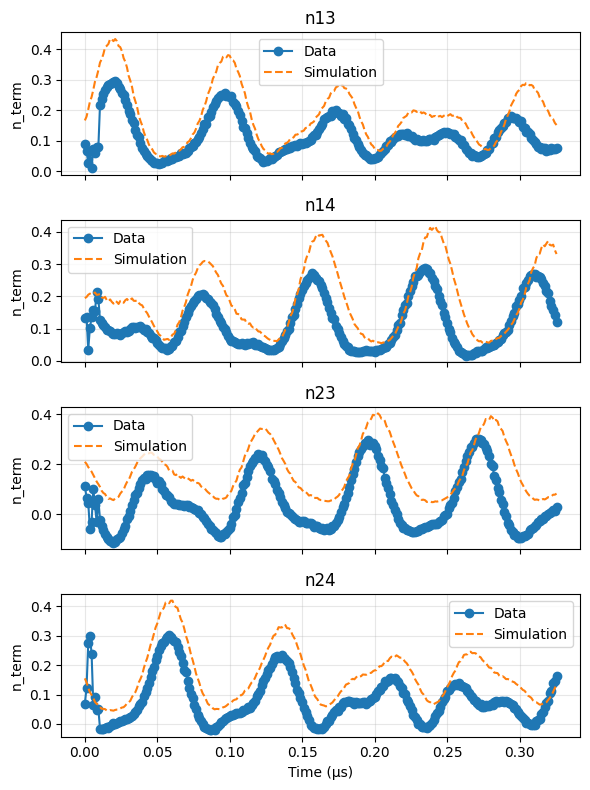

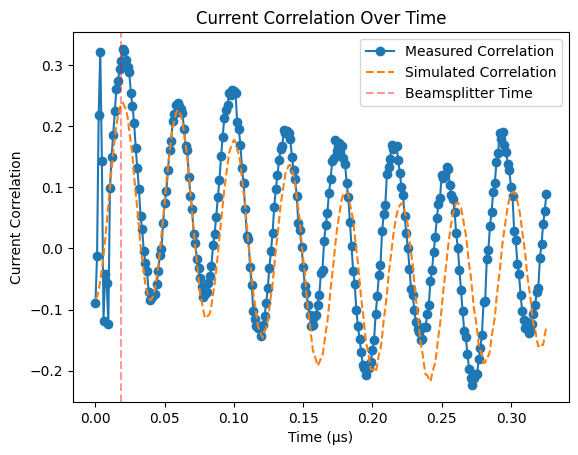

In [184]:
# Assuming n_terms_simulation has already been calculated and has the same shape as n_terms_data

# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
fig, axes = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
axes = axes.flatten()

labels = ['n13', 'n14', 'n23', 'n24']

for idx in range(4):
    axes[idx].plot(times, n_terms_data[idx], 'o-', label='Data')
    axes[idx].plot(times, n_terms_simulation[idx], '--', label='Simulation')
    axes[idx].set_title(labels[idx])
    axes[idx].set_ylabel('n_term')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

axes[-1].set_xlabel('Time (µs)')
plt.tight_layout()
plt.show()

plt.plot(times, current_correlation_data, 'o-', label='Measured Correlation')
plt.plot(times, current_correlation_simulation, '--', label='Simulated Correlation')
plt.axvline(beamsplitter_time/1e3, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')
plt.xlabel('Time (µs)')
plt.ylabel('Current Correlation')
plt.title('Current Correlation Over Time')
plt.legend()
plt.show()

assuming 0 flux

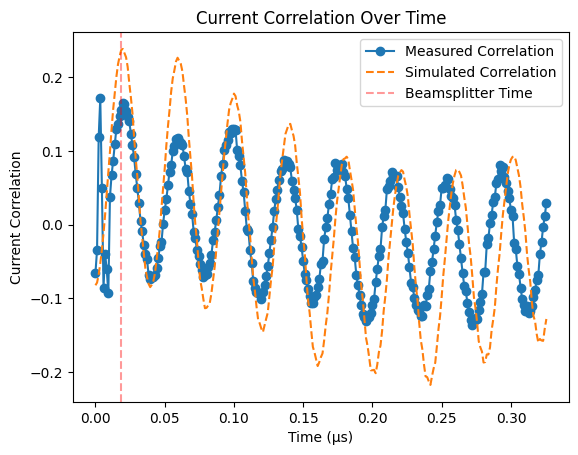

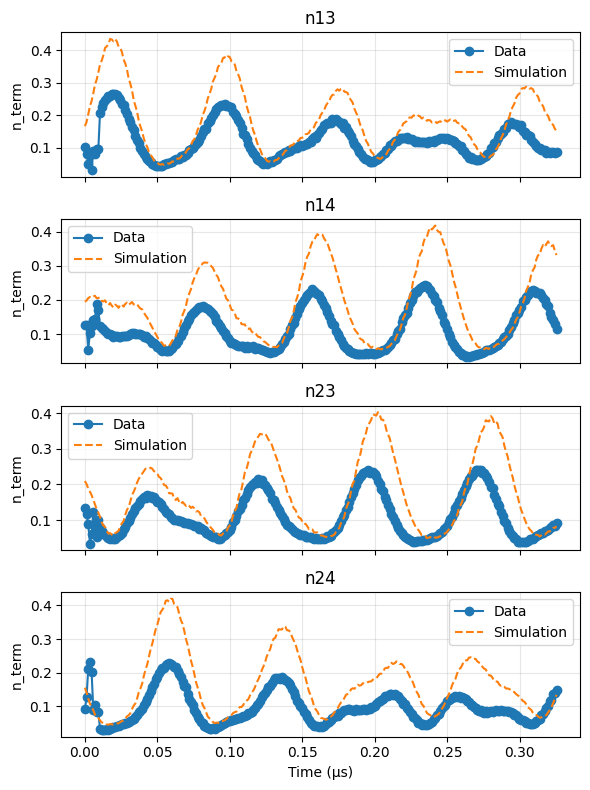

assuming pi flux

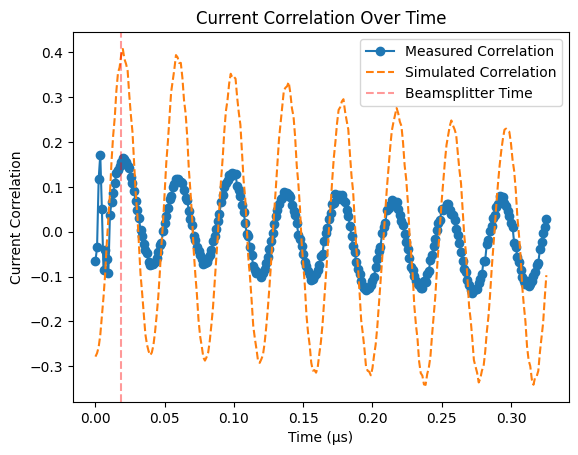

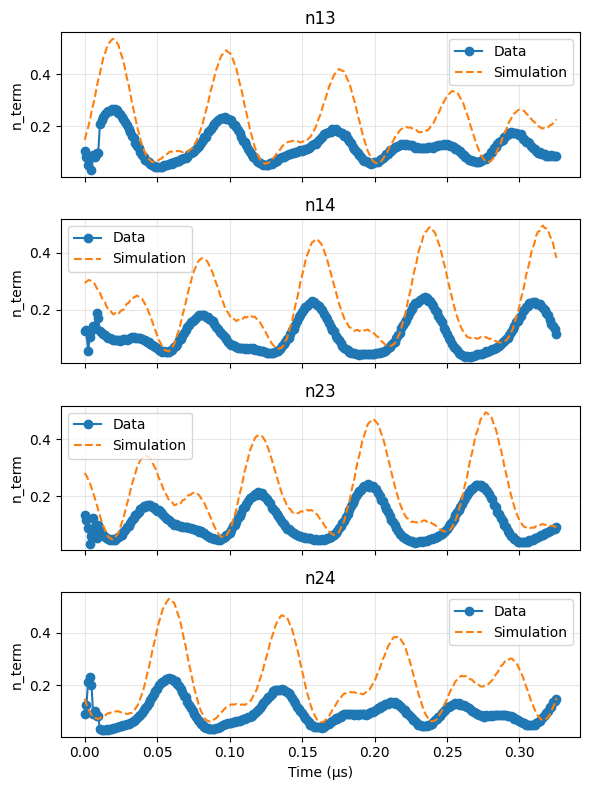

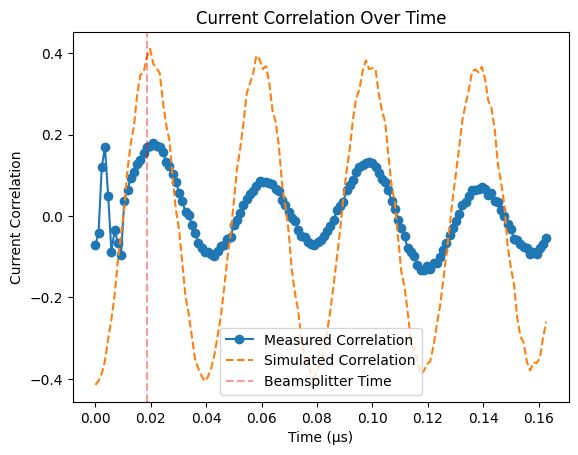

In [8]:
from scipy.optimize import minimize

# use initial detunings as fit parameter
objective_function = lambda x: cost_function(n_terms_data, calculate_n_terms_simulation(num_levels, num_qubits, J, J_parallel, U, times, readout_pair_1, readout_pair_2, x, measurement_detuning, measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel, psi0=psi0))


# use initial detunings and couplings fit parameter
objective_function = lambda x: cost_function(n_terms_data, calculate_n_terms_simulation(num_levels, num_qubits, x[:3], x[3:5], U, times, readout_pair_1, readout_pair_2, x[5:9], measurement_detuning, measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel, psi0=psi0))
# objective_function = lambda x: cost_function(n_terms_data, calculate_n_terms_simulation(num_levels, num_qubits, x[:3], x[3:5], U, times, readout_pair_1, readout_pair_2, x[5:9], measurement_detuning, scale_factor=x[7]))


# Initial guess: use the current initial_detunings
x0 = initial_detunings.copy()
x0 = np.concatenate([J.copy(), J_parallel.copy(), initial_detunings.copy()])
# x0 = np.concatenate([J.copy(), J_parallel.copy(), initial_detunings.copy(), [1]])

# Set bounds for J, J_parallel, and initial_detunings (all in x0)
# Example: allow each parameter to vary ±50% around its initial value
bounds = []

# if coupling strength is part of fit params
J_values = np.concatenate([J, J_parallel])  # Get the current value from J or J_parallel
for i in range(len(J_values)):
    val = J_values[i]
    delta = np.abs(val) * 0.8 if val != 0 else 10.0  # fallback for zero initial guess
    bounds.append((val - delta, val + delta))

for i in range(len(initial_detunings)):
    delta = 8 * 2 * np.pi # 5 MHz
    bounds.append((-delta, +delta))

# bounds.append((0.1, 1))

# result = minimize(objective_function, x0, method='Nelder-Mead', bounds=bounds)
result = minimize(objective_function, x0, bounds=bounds)



NameError: name 'initial_detunings' is not defined

In [ ]:
print("Optimization success:", result.success)
print("Final cost:", result.fun)

print('J =', list(result.x[:3]))
print('J_parallel =', list(result.x[3:5]))
print('initial_detunings =', list(result.x[5:]))

Optimization success: True
Optimal initial detunings (MHz): [-7.89632155 -6.23650898 -6.33555468  1.43064553  6.01054794 -0.22193152
 -0.67947126  0.71305628 -0.26734975]
Final cost: 0.5833726130983785
[-49.61405157308562, -39.18514156218579, -39.80746406231484]
[8.989010960218808, 37.76538653340438]
[-1.3944368630903539, -4.269243856812482, 4.480264741963223, -1.6798080153608281]


### 3.2 Fit populations

In [ ]:
def calculate_populations_simulation(num_levels=None, num_qubits=None, num_particles=None, J=None, J_parallel=None, U=None, times=None, 
                                     readout_pair_1=None, readout_pair_2=None, initial_detunings=None, measurement_detuning=None, 
                                     measurement_J=None, measurement_J_parallel=None, psi0=None, psi0_angles=None, psi0_bitstring=None, 
                                     T1=None, T2=None, scale_factor=1):


    current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, 
                                                                  readout_pair_1, readout_pair_2, initial_detunings, measurement_detuning, 
                                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel, 
                                                                  psi0=psi0, T1=T1, T2=T2)

    if psi0_angles is not None:
        current_measurement_simulation.psi0 = create_psi0_with_angles(psi0, current_measurement_simulation, num_levels, num_qubits, num_particles, psi0_angles, psi0_bitstring)

    ### modify initial state, manual for now


    q1_q2_phase = np.pi/4
    q3_q4_phase = np.pi/8
    pair_1 = [0, 1]
    pair_2 = [2, 3]

    current_measurement_simulation.psi0 = add_phase(current_measurement_simulation.psi0, current_measurement_simulation.number_operators, pair_1, pair_2, q1_q2_phase, q3_q4_phase)   ###

    current_measurement_simulation.run_simulation(False)

    populations = scale_factor * current_measurement_simulation.get_population_average()

    return populations

In [149]:
# state = 'CD'
# state = 'BD'
state = 'D'
# state = 'BC'
# state = 'A'
# state = 'B'

measurement = state_to_calibration_measurement[state]
populations_data = measurement.get_population_average()
# populations_data = measurement.get_population_corrected()

In [150]:
num_levels = 3
num_qubits = 4

# 0 flux
J = -np.array([6.74, 5.9, 5.79]) * 2 * np.pi # MHz
J_parallel = np.array([5.1, 5.38]) * 2 * np.pi # MHz

# pi flux
# J = -np.array([6.26, 5.9, 5.95]) * 2 * np.pi # MHz
# J_parallel = -np.array([7.25, 7.65]) * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz
psi0_angles = [np.pi, 0, np.pi, 0]  # theta_1, phi_1, theta_2, phi_2
scale_factor = 1.0



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()
measurement_detuning = 450 * 2 * np.pi  # MHz

measurement_detuning = np.array([310, 310, -280, -280]) * 2 * np.pi  # MHz


# CD optimal parameters
# J = [-54.39553963162486, -33.38041358117295, -34.928882382952196]
# J_parallel = [42.98870209960766, 32.14147480919956]
# initial_detunings = [-20.01543441228811, 1.8136169503169588, 13.030183916520134, -13.868236773272018]
# scale_factor = 0.7955503849206456
# psi0_angles = [2.694255790211729, 0.0039004156433469026, 3.098302515757088, 0.007121506599427584]

# CD optimal parameters pi flux
# J = [-42.348641374203126, -37.07073830167026, -36.37966613151129]
# J_parallel = [-45.553070108486416, -48.06637116603577]
initial_detunings = [2.415910794953103, 0.5700512866261311, -1.301588850183338, -1.6763688301887019]
scale_factor = 1.0


# BD optimal parameters
# J = [-42.42251314297556, -36.93919501587005, -36.24108666336282]
# J_parallel = [32.278878761473955, 33.6833783138587]
# initial_detunings = [-0.26941878220584736, -0.30241166298916355, 0.20937970298432584, 0.5093220750817061]
# scale_factor = 0.843312613620895
# psi0_angles = [3.141376722445573, 0.00012819212971035087, 3.1414471643204265, 0.00012826213901158564]

# D
# J = [-42.42251314297556, -36.93919501587005, -36.24108666336282]
# J_parallel = [32.278878761473955, 33.6833783138587]
# initial_detunings = [-0.26941878220584736, -0.30241166298916355, 0.20937970298432584, 0.5093220750817061]
# scale_factor = 0.843312613620895
# psi0_angles = None


print(f'J: {np.array(J)/(2*np.pi)}')
print(f'J_parallel: {np.array(J_parallel)/(2*np.pi)}')
print(f'detunings: {np.array(initial_detunings)/(2*np.pi)}')
print(f'scale factor: {np.array(scale_factor)}')
print(f'psi0_angles: {np.array(psi0_angles)}')


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]

# psi0 = 'highest_single_particle'


if state == 'CD':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '0011'

    # J = [-6.260000941439563, -5.899999931111843, -5.949999601217552]
    # J_parallel = [-7.250000551906229, -7.6500004022320764]
    # initial_detunings = [0.384504078712431, 0.09072611481765762, -0.20715438956821963, -0.26680254059262587]
elif state == 'BD':
    psi0 = -2
    num_particles = 2
    psi0_bitstring = '0101'

    J = [-39.331282832603534, -37.06898088863868, -37.38838075345022]
    J_parallel = [-45.55392879232946, -48.06372984582205]
    initial_detunings = [2.416169215327486, 0.5711553702615348, -1.3058535838147889, -1.6784808558931188]

elif state == 'BC':
    psi0 = -3
    num_particles = 2
    psi0_bitstring = '0110'

    J = [-39.362892207009956, -37.3440749877249, -37.392105048201365]
    J_parallel = [-45.521209291724986, -48.74037912832882]
    initial_detunings = [2.445986651069131, 0.607136101590656, -1.9544818788022733, -1.6815363507092163]


elif state == 'D':
    psi0 = -1
    num_particles = 1
    psi0_bitstring = '0001'
elif state == 'A':
    psi0 = 0
    num_particles = 1
    psi0_bitstring = '1000'

    J = [-6.26, -5.9, -5.949999999999999]
    J_parallel = [-7.25, -7.65]
    initial_detunings = [0.3845041450858568, 0.09072648008244362, -0.20715429937997465, -0.26680238576971]
    scale_factor = 0.8
    psi0_angles = [3.141592653589793, 0.0, 3.141592653589793, 0.0]

elif state == 'B':
    psi0 = 1
    num_particles = 1
    psi0_bitstring = '0100'

print(f'num_particles: {num_particles}')

populations_simulation = calculate_populations_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, psi0_angles=psi0_angles, psi0_bitstring=psi0_bitstring,
                                                  T1=T1, T2=T2)


# print(f'cost: {cost_function(populations_data, populations_simulation):.4f}')



J: [-6.74 -5.9  -5.79]
J_parallel: [5.1  5.38]
detunings: [ 0.38450415  0.09072648 -0.2071543  -0.26680239]
scale factor: 1.0
psi0_angles: [3.14159265 0.         3.14159265 0.        ]
num_particles: 1
X: -0.3725020719465874
Y: 0.3725020719465874
Z: -0.12061701387903673
running simulation
running mesolve


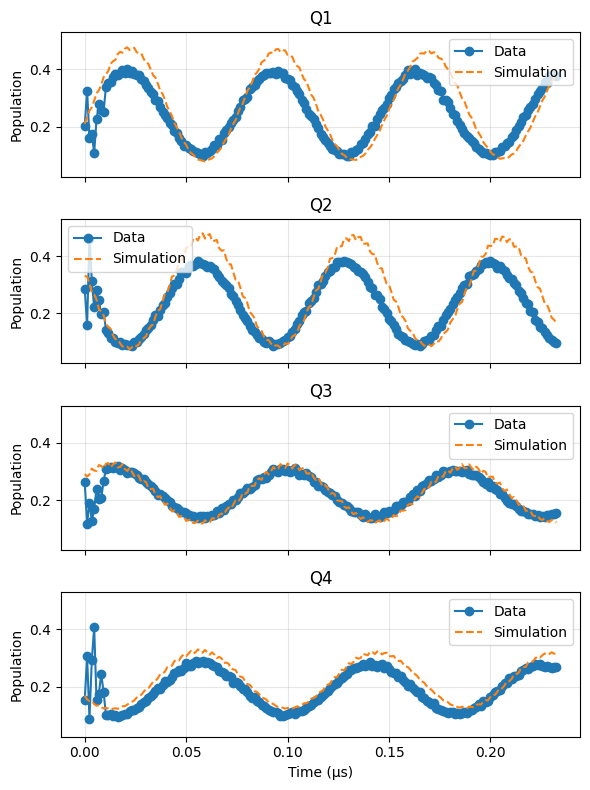

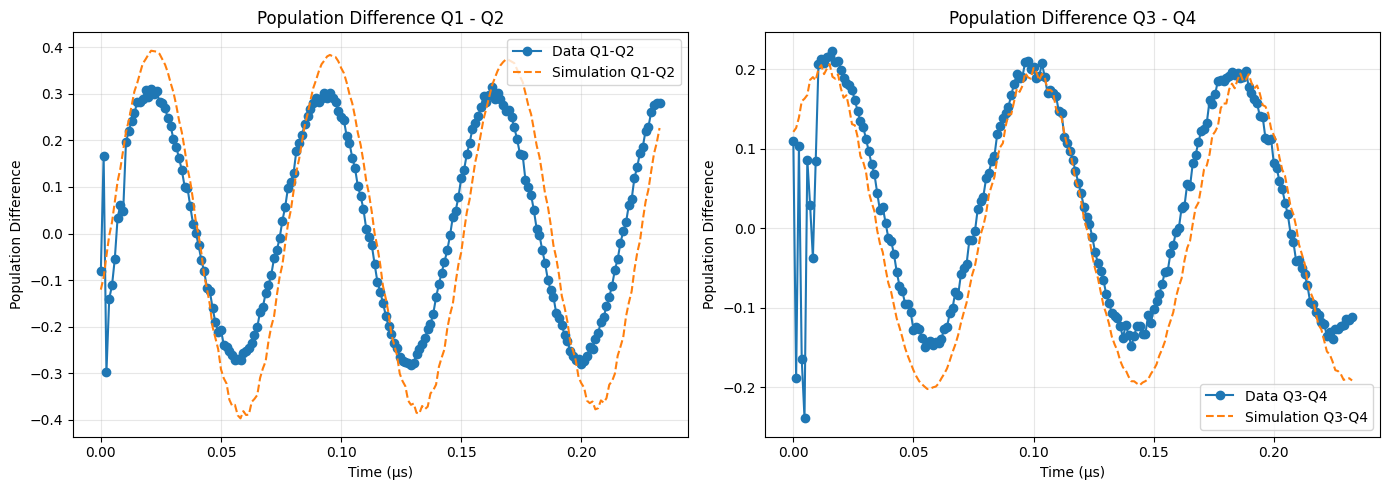

In [151]:
# Assuming populations_simulation has already been calculated and has the same shape as populations_data

# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
fig, axes = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
axes = axes.flatten()

time_step = times[1] - times[0]


# Set all axes to the same y-axis limits
ymin = min(np.min(populations_data), np.min(populations_simulation))
ymax = max(np.max(populations_data), np.max(populations_simulation))
for idx in range(4):
    axes[idx].plot(times, populations_data[idx], 'o-', label='Data')
    axes[idx].plot(times, populations_simulation[idx], '--', label='Simulation')
    axes[idx].set_title(f'Q{idx+1}')
    axes[idx].set_ylabel('Population')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    axes[idx].set_ylim(ymin - 0.05, ymax + 0.05)


axes[-1].set_xlabel('Time (µs)')
plt.tight_layout()
plt.show()

# Plot population differences for readout_pair_1 (Q1 - Q2) and readout_pair_2 (Q3 - Q4) using subplots

fig_diff, (axes_1, axes_2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Data differences
pop_diff_1_data = populations_data[readout_pair_1[0]] - populations_data[readout_pair_1[1]]
pop_diff_2_data = populations_data[readout_pair_2[0]] - populations_data[readout_pair_2[1]]

# Simulation differences
pop_diff_1_sim = populations_simulation[readout_pair_1[0]] - populations_simulation[readout_pair_1[1]]
pop_diff_2_sim = populations_simulation[readout_pair_2[0]] - populations_simulation[readout_pair_2[1]]

# Plot for readout_pair_1
axes_1.plot(times, pop_diff_1_data, 'o-', label='Data Q1-Q2')
axes_1.plot(times, pop_diff_1_sim, '--', label='Simulation Q1-Q2')
axes_1.set_title('Population Difference Q1 - Q2')
axes_1.set_xlabel('Time (µs)')
axes_1.set_ylabel('Population Difference')
axes_1.legend()
axes_1.grid(True, alpha=0.3)

# Plot for readout_pair_2
axes_2.plot(times, pop_diff_2_data, 'o-', label='Data Q3-Q4')
axes_2.plot(times, pop_diff_2_sim, '--', label='Simulation Q3-Q4')
axes_2.set_title('Population Difference Q3 - Q4')
axes_2.set_xlabel('Time (µs)')
axes_2.set_ylabel('Population Difference')
axes_2.legend()
axes_2.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


In [131]:
print(f'offset time in nanoseconds: {time_offset*time_step*1e3:.2f} ns')

frequency_difference = 0.280 # GHz

print(time_offset*time_step*1e3*frequency_difference)


offset time in nanoseconds: -21.80 ns
-6.103518750000001


In [66]:
simulation_kwargs = dict(
    num_levels=num_levels,
    num_qubits=num_qubits,
    num_particles=num_particles,
    J=J,
    J_parallel=J_parallel,
    U=U,
    times=times,
    readout_pair_1=readout_pair_1,
    readout_pair_2=readout_pair_2,
    initial_detunings=initial_detunings,
    measurement_detuning=measurement_detuning,
    measurement_J=measurement_J,
    measurement_J_parallel=measurement_J_parallel,
    psi0=psi0,
    scale_factor=scale_factor,
    psi0_angles=psi0_angles,
    psi0_bitstring=psi0_bitstring
)

print(f'simulation_kwargs: {simulation_kwargs}')

initial_guess_dict = dict(
    J=J.copy(),
    J_parallel=J_parallel.copy(),
    initial_detunings=initial_detunings.copy(),
    scale_factor=scale_factor,
    psi0_angles=psi0_angles.copy()
)

J_delta_ratio = 0.8
detuning_bound = 8 * 2 * np.pi  # 5 MHz

bounds_dict = dict(
    J=[(val - np.abs(val) * J_delta_ratio, val + np.abs(val) * J_delta_ratio) for val in J],
    J_parallel=[(val - np.abs(val) * J_delta_ratio, val + np.abs(val) * J_delta_ratio) for val in J_parallel],
    initial_detunings=[(-detuning_bound, detuning_bound) for _ in initial_detunings],
    scale_factor=(0.2, 1),
    psi0_angles=[(0, np.pi) if i in [0, 2] else (0, 2 * np.pi) for i in range(len(psi0_angles))]
)


def create_objective_function(_fit_params, _simulation_kwargs, _initial_guess_dict, _bounds_dict):

    key_to_indices = {}
    index_counter = 0

    initial_guess_list = []
    bounds_list = []

    for key in _simulation_kwargs:
        if key in _fit_params:
            initial_guess = _initial_guess_dict[key]
            bounds = _bounds_dict[key]

            if isinstance(bounds, list):
                bounds_list.extend(bounds)
            else:
                bounds_list.append(bounds)

            if isinstance(initial_guess, (list, tuple, np.ndarray)):
                initial_guess_list.extend(initial_guess)

                variable_length = len(initial_guess)
                key_to_indices[key] = (index_counter, index_counter + variable_length)
                index_counter += variable_length
            else:
                initial_guess_list.append(initial_guess)

                key_to_indices[key] = (index_counter, index_counter + 1)
                index_counter += 1

    def objective_function(x):
        """
        Objective function to minimize.
        x is a flat array containing all parameters in the order defined by key_to_indices.
        """
        # Extract parameters based on key_to_indices
        params = simulation_kwargs.copy()
        for key, (start, end) in key_to_indices.items():
            params[key] = x[start:end] if end - start > 1 else x[start]

        # Calculate the N-terms data from the simulation
        populations_simulation = calculate_populations_simulation(**params)

        # Calculate the cost function as the sum squared error between measured and simulated N-terms
        return cost_function(populations_data, populations_simulation)

    return objective_function, key_to_indices, initial_guess_list, bounds_list


        
fit_params = ['J', 'J_parallel', 'initial_detunings', 'scale_factor', 'psi0_angles']

objective_function, key_to_indices, initial_guess, bounds = create_objective_function(fit_params, simulation_kwargs, initial_guess_dict, bounds_dict)

print(objective_function)
print("Key to Indices:", key_to_indices)
print("Initial Guess:", initial_guess)
print("Bounds:", bounds)


result = minimize(objective_function, initial_guess, bounds=bounds)
print("Optimization success:", result.success)
print("Final cost:", result.fun)

for key in fit_params:
    start, end = key_to_indices[key]
    if end - start > 1:
        print(f"{key} = {list(result.x[start:end])}")
    else:
        print(f"{key} = {result.x[start]}")


simulation_kwargs: {'num_levels': 3, 'num_qubits': 4, 'num_particles': 2, 'J': [-39.35692175773924, -37.34998640048188, -37.42656587325599], 'J_parallel': [-45.52485872340746, -48.72660206513294], 'U': -1130.9733552923256, 'times': array([0.        , 0.00145322, 0.00290644, 0.00435966, 0.00581288,
       0.00726609, 0.00871931, 0.01017253, 0.01162575, 0.01307897,
       0.01453219, 0.01598541, 0.01743862, 0.01889184, 0.02034506,
       0.02179828, 0.0232515 , 0.02470472, 0.02615794, 0.02761116,
       0.02906437, 0.03051759, 0.03197081, 0.03342403, 0.03487725,
       0.03633047, 0.03778369, 0.03923691, 0.04069012, 0.04214334,
       0.04359656, 0.04504978, 0.046503  , 0.04795622, 0.04940944,
       0.05086266, 0.05231587, 0.05376909, 0.05522231, 0.05667553,
       0.05812875, 0.05958197, 0.06103519, 0.06248841, 0.06394163,
       0.06539484, 0.06684806, 0.06830128, 0.0697545 , 0.07120772,
       0.07266094, 0.07411416, 0.07556738, 0.07702059, 0.07847381,
       0.07992703, 0.08138025, 

In [67]:
print(result.fun)

for key in fit_params:
    start, end = key_to_indices[key]
    if end - start > 1:
        print(f"{key} = {list(result.x[start:end])}")
    else:
        print(f"{key} = {result.x[start]}")

print()
print(f'MHz:')
for key in fit_params:
    factor = 1
    if key in ['J', 'J_parallel', 'initial_detunings']:
        factor = 2 * np.pi
    start, end = key_to_indices[key]
    if end - start > 1:
        print(f"{key} = {list(result.x[start:end]/factor)}")
    else:
        print(f"{key} = {result.x[start]/factor}")

3.45320455324348
J = [-39.362892207009956, -37.3440749877249, -37.392105048201365]
J_parallel = [-45.521209291724986, -48.74037912832882]
initial_detunings = [2.445986651069131, 0.607136101590656, -1.9544818788022733, -1.6815363507092163]
scale_factor = 1.0
psi0_angles = [3.1415738768264307, 2.3904902808115672e-11, 3.1415591223320436, 2.3898492252767795e-11]

MHz:
J = [-6.264798869139081, -5.943494129490829, -5.951138351032661]
J_parallel = [-7.244925474298747, -7.757272266446576]
initial_detunings = [0.3892908662544432, 0.09662871169769605, -0.3110654521949165, -0.2676248222040787]
scale_factor = 1.0
psi0_angles = [3.1415738768264307, 2.3904902808115672e-11, 3.1415591223320436, 2.3898492252767795e-11]


# 4. Try Different States

Processing state CD with beamsplitter time 21.19 ns


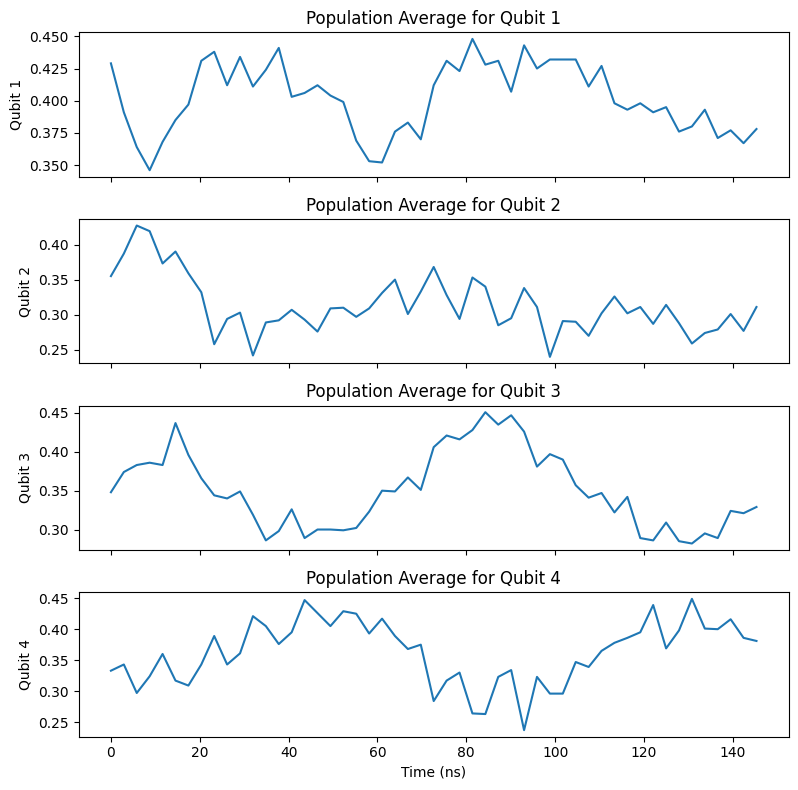

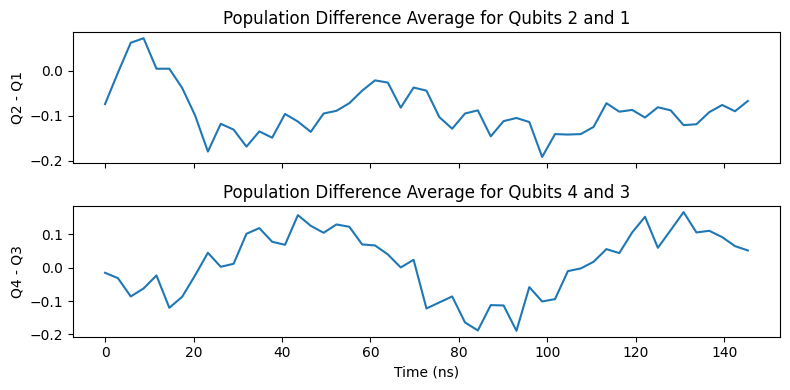

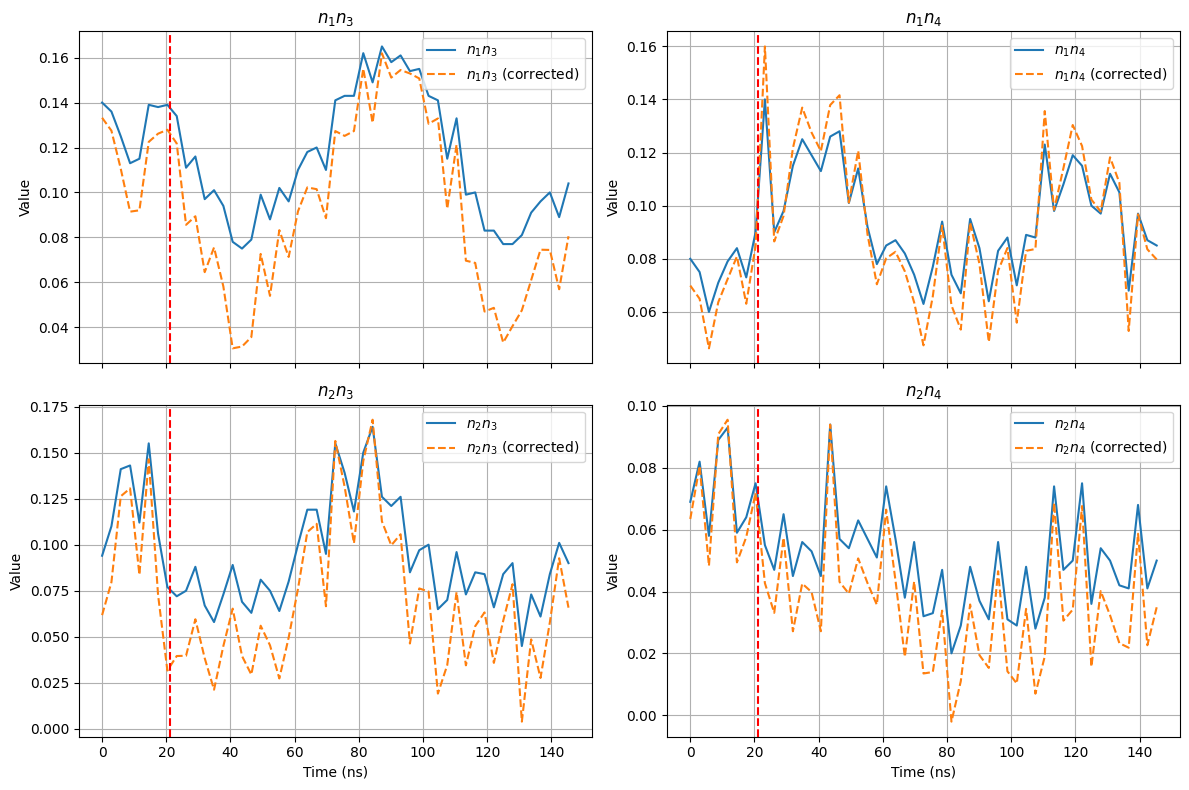

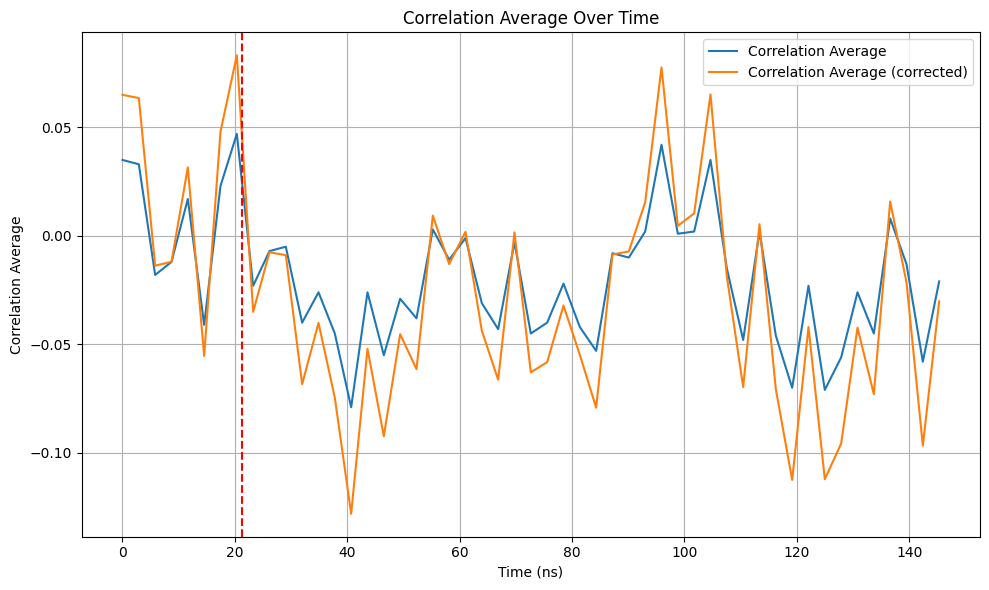


Processing state BD with beamsplitter time 21.19 ns


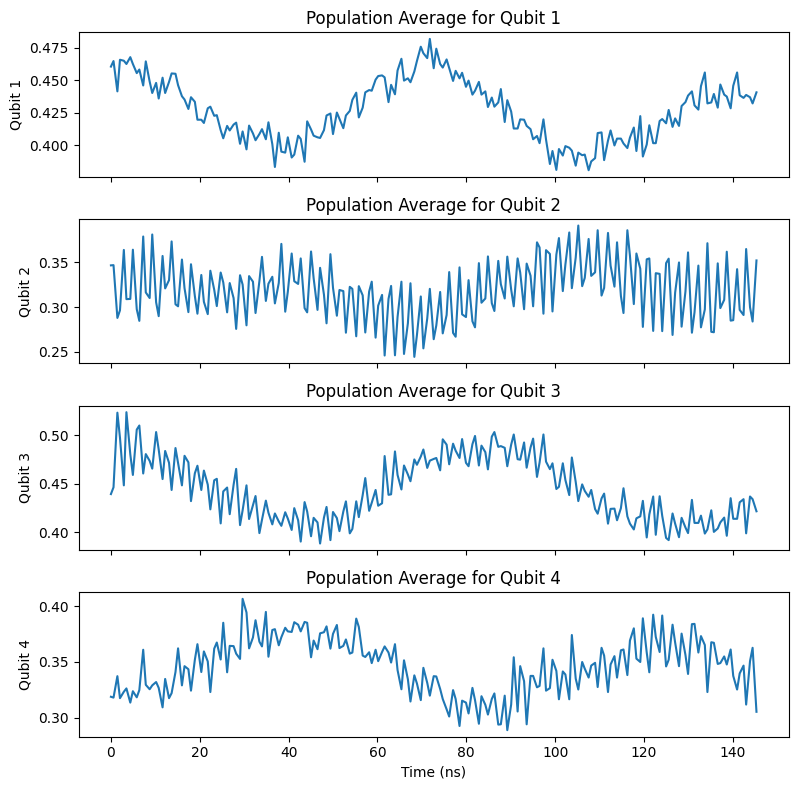

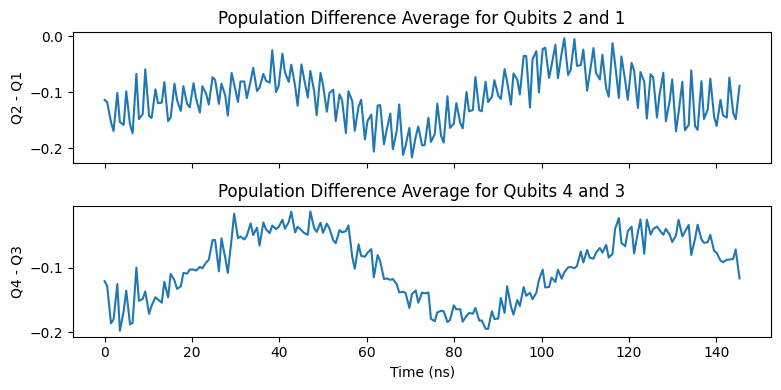

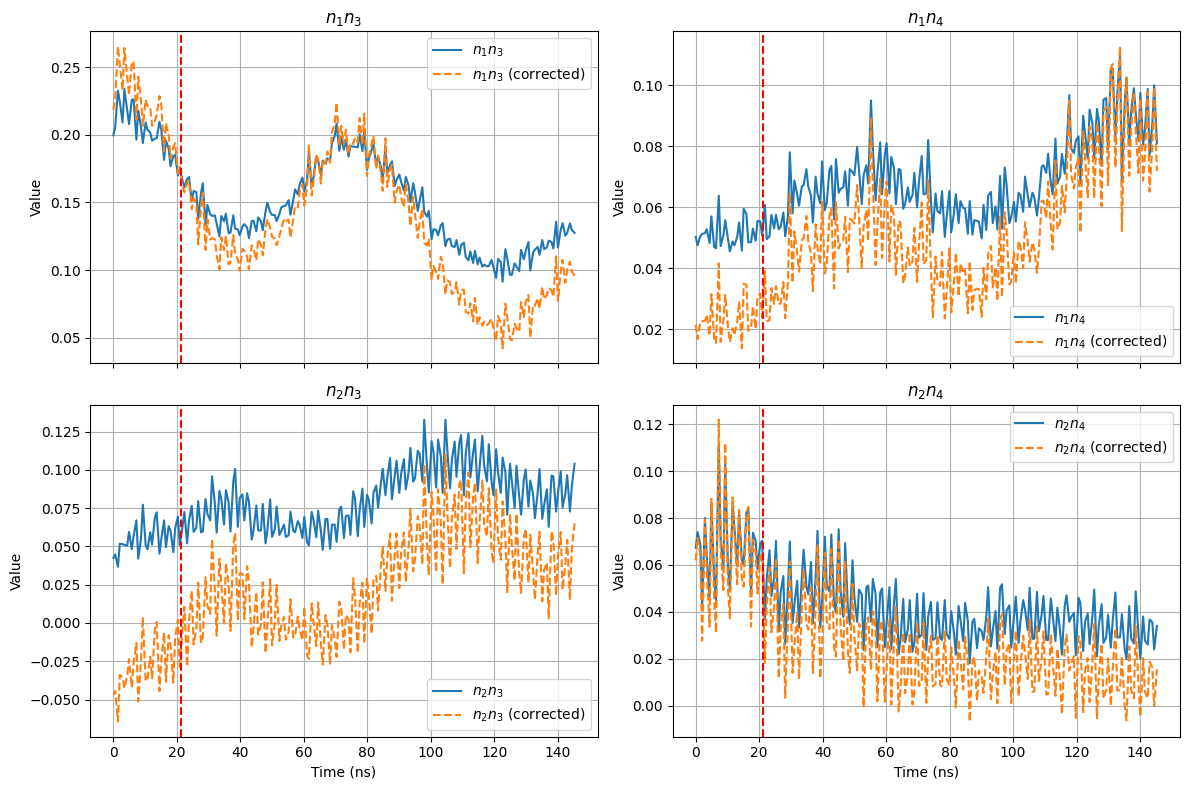

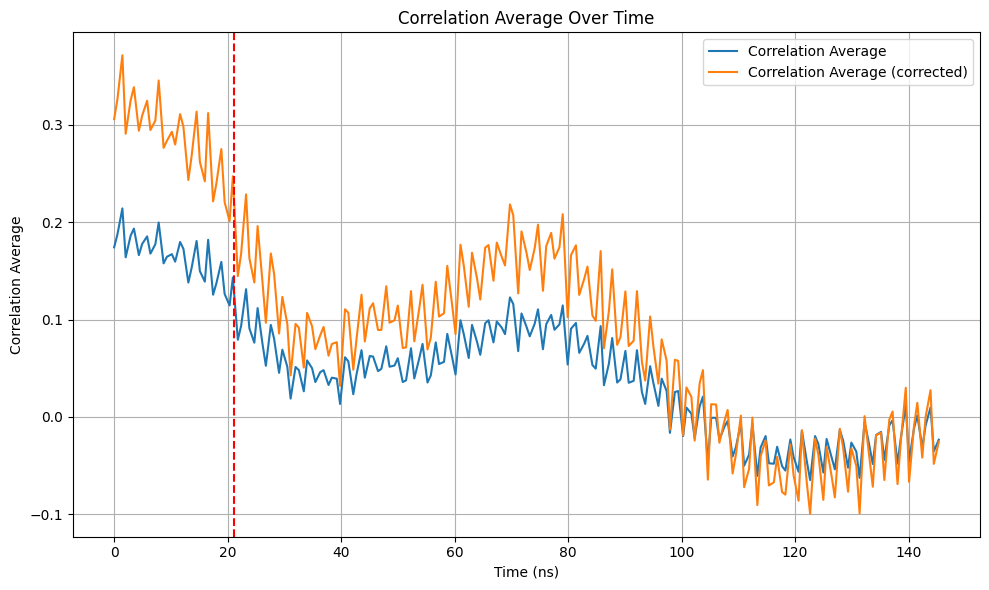


Processing state BC with beamsplitter time 21.19 ns


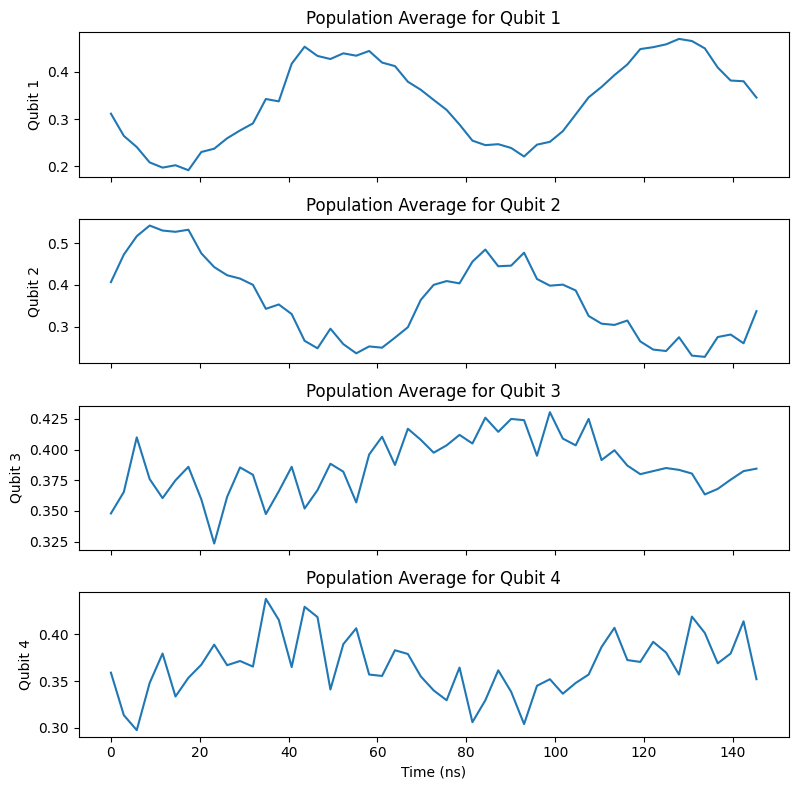

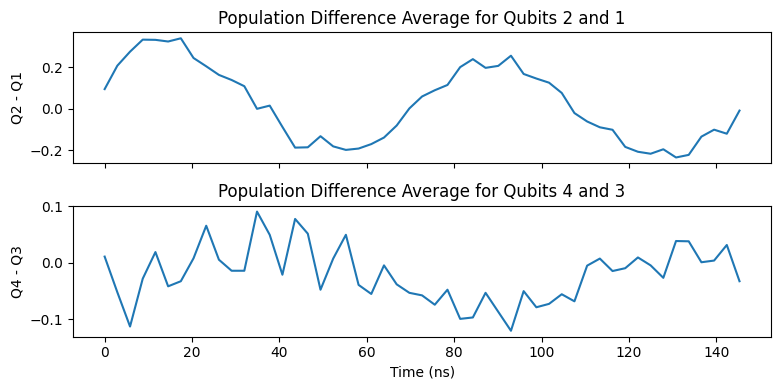

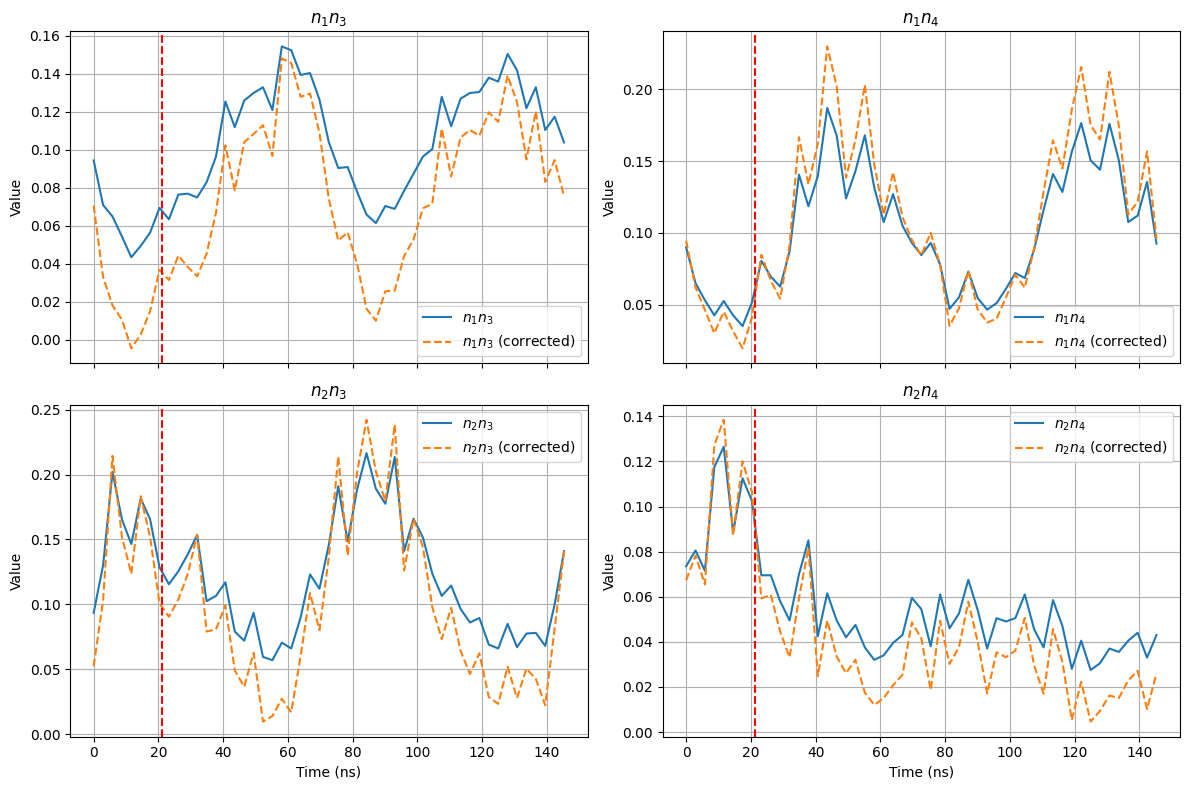

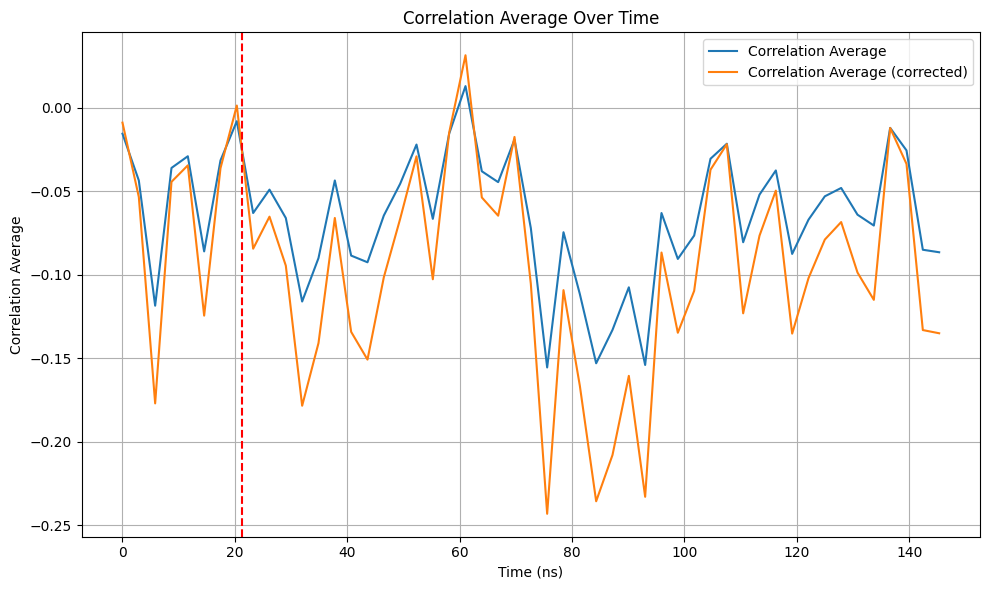


Processing state D with beamsplitter time 21.19 ns


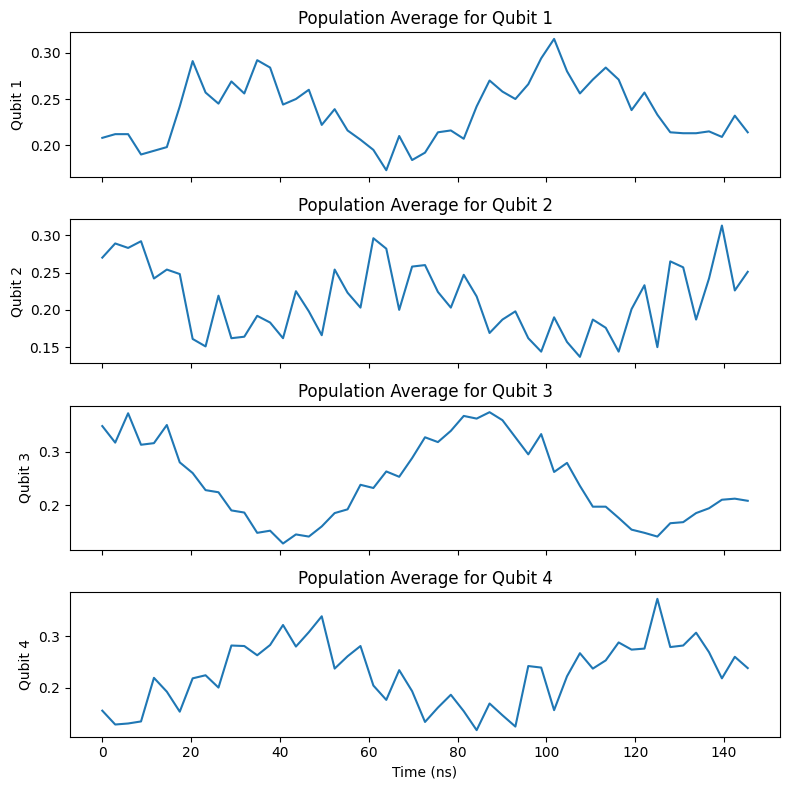

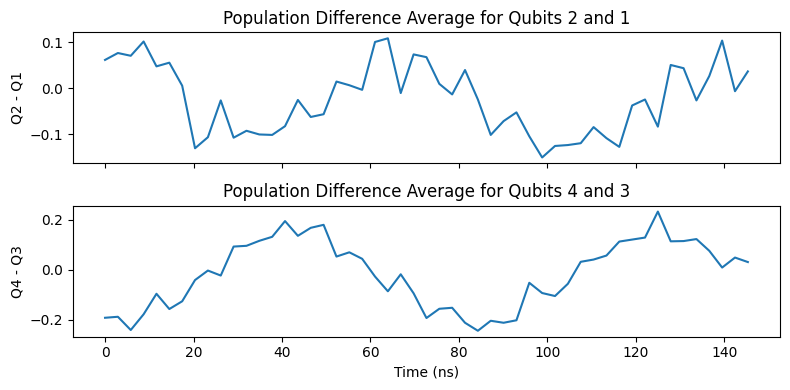

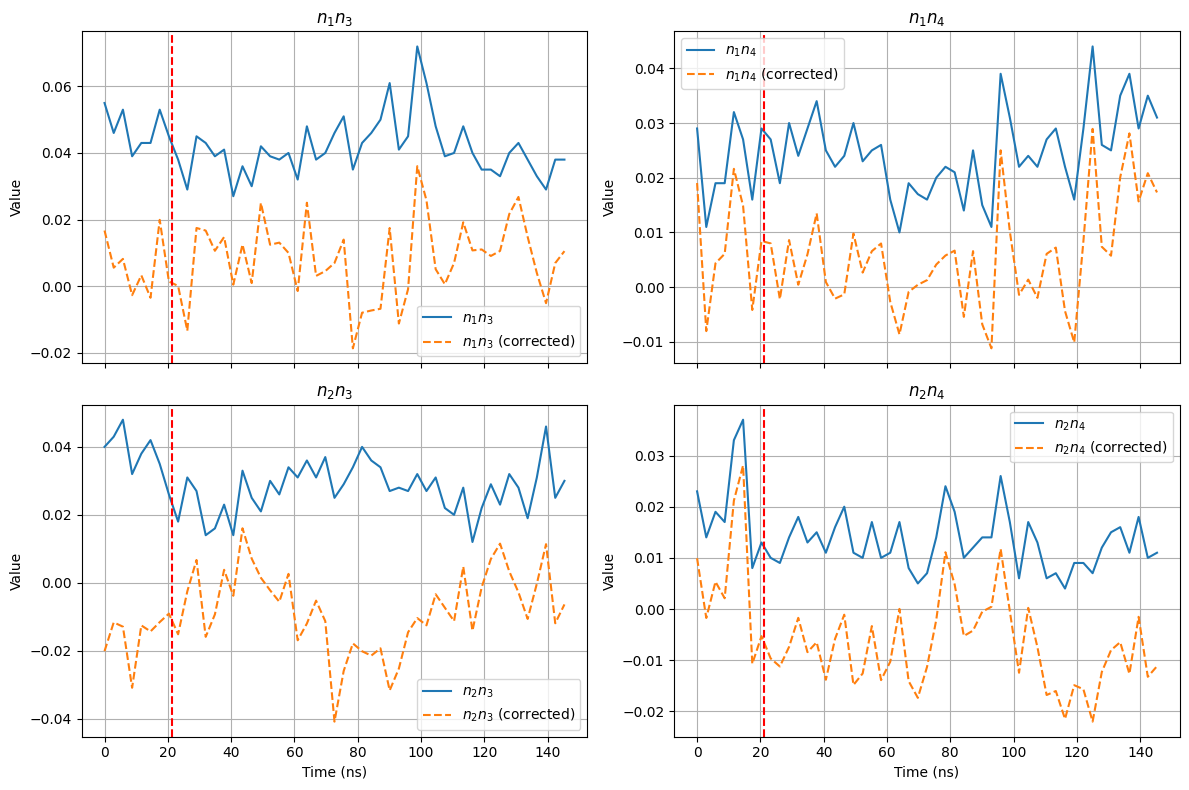

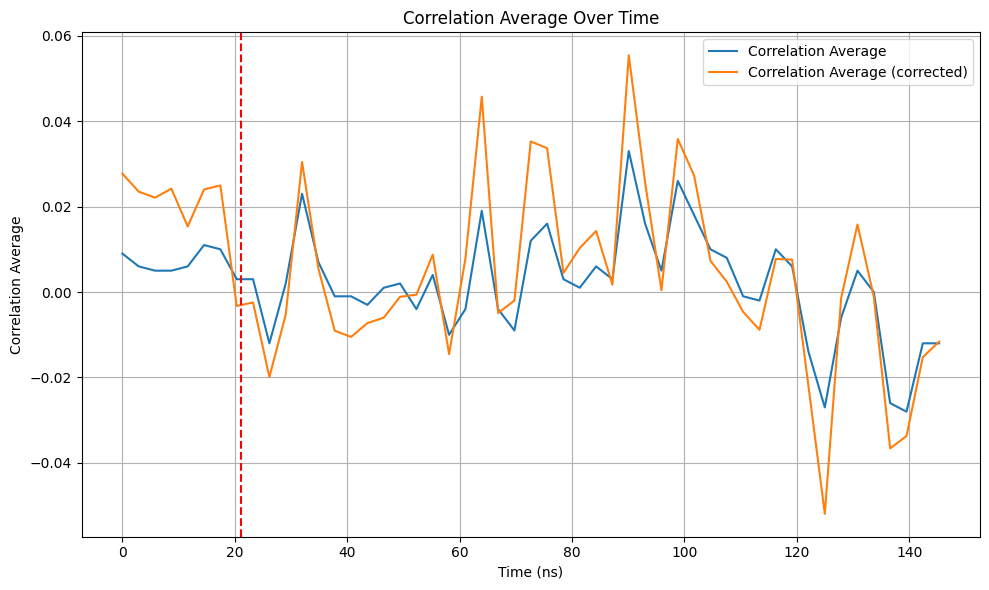

In [44]:
J = 5.9 * 2 * np.pi

beamsplitter_time = J_to_beamsplitter_time(J)

for state in state_to_calibration_measurement:
    print(f"Processing state {state} with beamsplitter time {beamsplitter_time:.2f} ns")
    state_to_calibration_measurement[state].plot_population_average()
    state_to_calibration_measurement[state].plot_population_difference_average()

    state_to_calibration_measurement[state].plot_n_terms(both=True, beamsplitter_time=beamsplitter_time)

    state_to_calibration_measurement[state].plot_correlation_average(both=True, beamsplitter_time=beamsplitter_time)

    print()



In [197]:
### test eigenstate current correlations

current_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  T1=T1, T2=T2)

current_simulation.run_simulation(True)
result = current_simulation.get_simulation_result()

current_correlation = [qt.expect(current_simulation.current_correlator, state) for state in result.states]

running simulation
running mesolve


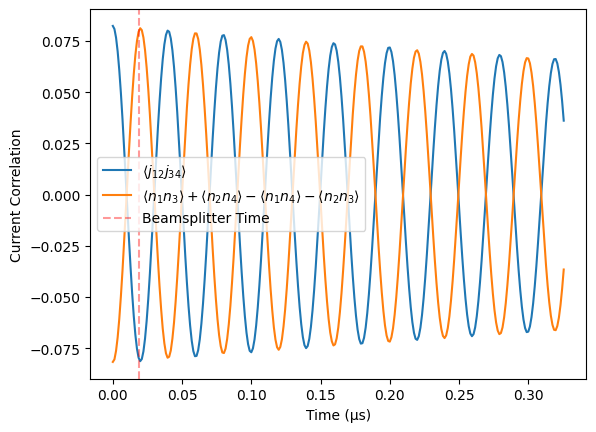

In [205]:
plt.plot(times, current_correlation/(J[0]*J[-1]), label=r'$\langle j_{12}j_{34} \rangle$')
population_average = current_simulation.get_population_average()
covariance_sum = current_simulation.get_current_correlation()
covariance_sum += -population_average[0]*population_average[2] - population_average[1]*population_average[3]
covariance_sum += population_average[0]*population_average[3] + population_average[1]*population_average[2]
plt.plot(times, covariance_sum, label=r'$\langle n_1n_3 \rangle + \langle n_2n_4 \rangle - \langle n_1n_4 \rangle - \langle n_2n_3 \rangle$')

plt.xlabel('Time (µs)')
plt.ylabel('Current Correlation')

plt.axvline(abs(J_to_beamsplitter_time(J[0]))/1e3, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')

plt.legend()
plt.show()